# 🐕 DetectoDog: Dog Breed Classification

## Project Overview

DetectoDog is a deep learning model that accurately identifies dog breeds from images. This project demonstrates the complete machine learning workflow from data preparation to model deployment, using transfer learning with state-of-the-art convolutional neural networks.

### Dataset
The Stanford Dogs Dataset contains images of 120 breeds of dogs from around the world. The dataset includes:
- 20,580 total images
- 120 different dog breeds
- Approximately 150-200 images per breed
- Varying image quality, angles, and backgrounds

### Approach
This project uses transfer learning with three different backbone architectures:
- **ResNet50**: Deep residual network with excellent feature extraction capabilities
- **MobileNetV2**: Lightweight architecture optimized for mobile devices
- **EfficientNet**: State-of-the-art model with optimal accuracy/efficiency tradeoff

### Key Features
- ✅ Comprehensive data preprocessing and augmentation
- ✅ Transfer learning with multiple CNN architectures
- ✅ Hyperparameter optimization strategies
- ✅ Performance comparison across architectures
- ✅ Detailed visualization and analysis

In [139]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
import tarfile
import scipy.io
from tqdm.notebook import tqdm
from datetime import datetime
import csv
import sys
import yaml
import json
from sklearn.metrics import confusion_matrix, classification_report

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

if device.type == "cuda":
    print(f"🧮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🧠 Available VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU detected. Training will be slower on CPU.")

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Display PyTorch and Torchvision versions
print(f"📦 PyTorch version: {torch.__version__}")
print(f"📦 Torchvision version: {torchvision.__version__}")


# Detect if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules

# Set up paths based on environment
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    # Set Google Drive paths
    base_path = "/content/drive/MyDrive/"
    experiments_dir = base_path + "experiments"
    
    # Create directories in Google Drive
    os.makedirs(experiments_dir, exist_ok=True)
    print(f"✅ Google Drive mounted and experiments directory ensured: {experiments_dir}")
else:
    # Local paths
    base_path = ""
    experiments_dir = "experiments"
    os.makedirs(experiments_dir, exist_ok=True)
    print(f"✅ Local experiments directory ensured: {experiments_dir}")

🖥️ Using device: cpu
⚠️ No GPU detected. Training will be slower on CPU.
📦 PyTorch version: 2.6.0+cu124
📦 Torchvision version: 0.21.0+cu124
✅ Local experiments directory ensured: experiments


In [140]:
class Config:
    """
    Configuration class for managing training and model parameters
    
    This class centralizes all configuration parameters and provides
    methods for saving/loading configurations.
    """
    def __init__(self, config_dict=None):
        """
        Initialize configuration with default values or from a dictionary
        
        Args:
            config_dict: Optional dictionary with configuration values
        """
        # Set default values
        self.set_defaults()
        
        # Update with provided dictionary if any
        if config_dict:
            for key, value in config_dict.items():
                setattr(self, key, value)
        
        # Automatically check for GPU
        self.use_gpu = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_gpu else "cpu")
        
        # Derive experiment name if not set
        if not hasattr(self, 'experiment_name') or not self.experiment_name:
            self.experiment_name = f"{self.backbone}_{self.lr_strategy}_{datetime.now().strftime('%Y%m%d_%H%M')}"
        
        # Apply device-specific adjustments
        self._adjust_for_device()
    
    def set_defaults(self):
        """Set default configuration values"""
        # General settings
        self.experiment_name = None
        self.device = "cpu"
        self.seed = 42
        
        # Model configuration
        self.backbone = "efficientnet"  # Options: "resnet50", "mobilenetv2", "efficientnet"
        self.dropout_rate = 0.3
        self.freeze_backbone = False
        
        # Dataset configuration
        self.image_size = (224, 224)
        self.use_augmentation = True
        
        # Training configuration
        self.batch_size = 16
        self.num_epochs = 25
        self.lr_strategy = "cyclic"  # Options: "cyclic", "fixed"
        self.fixed_lr = 0.0001
        self.cyclic_base_lr = 0.00001
        self.cyclic_max_lr = 0.00005
        self.cyclic_step_size = 340  # = 5 epochs * 68 batches per epoch
        
        # Paths
        self.in_colab = 'google.colab' in sys.modules
        self.base_path = "/content/drive/MyDrive/" if self.in_colab else ""
        self.experiments_dir = os.path.join(self.base_path, "experiments")
        self.dataset_path = os.path.join(self.base_path, "dataset/Images")
        self.log_dir = os.path.join(self.base_path, "logs")
        self.checkpoint_dir = os.path.join(self.base_path, "checkpoints")
        self.experiment_csv = os.path.join(self.experiments_dir, "training_runs_v4.csv")
    
    def _adjust_for_device(self):
        """Adjust parameters based on the device (CPU/GPU)"""
        if self.device.type == "cpu":
            # Reduce workload for CPU training
            self.batch_size = min(8, self.batch_size)
            self.num_epochs = min(3, self.num_epochs)
            
            # Use smaller images for faster processing
            if self.backbone == "efficientnet":
                self.image_size = (128, 128)
            else:
                self.image_size = (128, 128)
            
            print("⚠️ Running on CPU – Using smaller dataset and fewer epochs for faster training.")
        else:
            # Optimize for GPU
            if self.backbone == "efficientnet":
                self.image_size = (240, 240)  # EfficientNet prefers larger images
            
            print(f"✅ Running on GPU: {torch.cuda.get_device_name(0)}")
    
    def save(self, filepath):
        """
        Save the configuration to a file
        
        Args:
            filepath: Path to save the configuration
        """
        # Convert to dictionary
        config_dict = {k: v for k, v in self.__dict__.items() 
                      if not k.startswith('_') and not callable(v)}
        
        # Handle non-serializable types
        if 'device' in config_dict:
            config_dict['device'] = str(config_dict['device'])
        
        # Save based on file extension
        ext = os.path.splitext(filepath)[1].lower()
        
        if ext == '.yaml' or ext == '.yml':
            with open(filepath, 'w') as f:
                yaml.dump(config_dict, f, default_flow_style=False)
        elif ext == '.json':
            with open(filepath, 'w') as f:
                json.dump(config_dict, f, indent=4)
        else:
            # Default to JSON
            with open(filepath, 'w') as f:
                json.dump(config_dict, f, indent=4)
        
        print(f"✅ Configuration saved to {filepath}")
    
    @classmethod
    def load(cls, filepath):
        """
        Load configuration from a file
        
        Args:
            filepath: Path to the configuration file
            
        Returns:
            Config: Configuration object
        """
        ext = os.path.splitext(filepath)[1].lower()
        
        if ext == '.yaml' or ext == '.yml':
            with open(filepath, 'r') as f:
                config_dict = yaml.safe_load(f)
        elif ext == '.json':
            with open(filepath, 'r') as f:
                config_dict = json.load(f)
        else:
            raise ValueError(f"Unsupported file extension: {ext}")
        
        return cls(config_dict)
    
    def __str__(self):
        """Return a string representation of the configuration"""
        lines = ["📋 CONFIGURATION:"]
        lines.append("=" * 50)
        
        # General settings
        lines.append("📌 General Settings:")
        lines.append(f"  • Experiment Name: {self.experiment_name}")
        lines.append(f"  • Device: {self.device}")
        lines.append(f"  • Random Seed: {self.seed}")
        
        # Model configuration
        lines.append("\n📌 Model Configuration:")
        lines.append(f"  • Backbone: {self.backbone}")
        lines.append(f"  • Dropout Rate: {self.dropout_rate}")
        lines.append(f"  • Freeze Backbone: {self.freeze_backbone}")
        
        # Dataset configuration
        lines.append("\n📌 Dataset Configuration:")
        lines.append(f"  • Image Size: {self.image_size}")
        lines.append(f"  • Data Augmentation: {self.use_augmentation}")
        
        # Training configuration
        lines.append("\n📌 Training Configuration:")
        lines.append(f"  • Batch Size: {self.batch_size}")
        lines.append(f"  • Num Epochs: {self.num_epochs}")
        lines.append(f"  • Learning Rate Strategy: {self.lr_strategy}")
        
        if self.lr_strategy == "fixed":
            lines.append(f"  • Learning Rate: {self.fixed_lr}")
        else:
            lines.append(f"  • Cyclic Base LR: {self.cyclic_base_lr}")
            lines.append(f"  • Cyclic Max LR: {self.cyclic_max_lr}")
            lines.append(f"  • Cyclic Step Size: {self.cyclic_step_size}")
        
        # Paths
        lines.append("\n📌 Paths:")
        lines.append(f"  • Dataset Path: {self.dataset_path}")
        lines.append(f"  • Log Directory: {self.log_dir}")
        lines.append(f"  • Checkpoint Directory: {self.checkpoint_dir}")
        lines.append(f"  • Experiment CSV: {self.experiment_csv}")
        
        lines.append("=" * 50)
        
        return "\n".join(lines)

In [141]:
# Create configuration for this experiment
config = Config({
    "experiment_name": "detectodog_improved",
    "backbone": "efficientnet",  # Options: "resnet50", "mobilenetv2", "efficientnet"
    "experiment_csv": "training_runs_v4.csv",
    "lr_strategy": "cyclic",
    "use_augmentation": True,
    "dropout_rate": 0.3,
    "experiments_dir": "experiments",
    "experiment_csv": "experiments/training_runs_v4.csv"
})

# Display configuration
print(config)

# Create directories
os.makedirs(config.log_dir, exist_ok=True)
os.makedirs(config.checkpoint_dir, exist_ok=True)

⚠️ Running on CPU – Using smaller dataset and fewer epochs for faster training.
📋 CONFIGURATION:
📌 General Settings:
  • Experiment Name: detectodog_improved
  • Device: cpu
  • Random Seed: 42

📌 Model Configuration:
  • Backbone: efficientnet
  • Dropout Rate: 0.3
  • Freeze Backbone: False

📌 Dataset Configuration:
  • Image Size: (128, 128)
  • Data Augmentation: True

📌 Training Configuration:
  • Batch Size: 8
  • Num Epochs: 3
  • Learning Rate Strategy: cyclic
  • Cyclic Base LR: 1e-05
  • Cyclic Max LR: 5e-05
  • Cyclic Step Size: 340

📌 Paths:
  • Dataset Path: dataset/Images
  • Log Directory: logs
  • Checkpoint Directory: checkpoints
  • Experiment CSV: experiments/training_runs_v4.csv



## 📥 Dataset Download and Extraction

We'll download the Stanford Dogs Dataset which contains images of 120 dog breeds.

In [142]:
# Download and Extract Dataset (can be skipped if dataset already exists)

def download_and_extract_dataset():
    """Download and extract the Stanford Dogs Dataset"""
    
    # Set paths
    dataset_path = "images.tar"
    list_path = "lists.tar"
    
    # Download dataset
    if not os.path.exists(dataset_path):
        print("Downloading dataset images (this may take a while)...")
        os.system(f"wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar")
    else:
        print(f"✅ Dataset images already downloaded: {dataset_path}")
    
    # Download lists
    if not os.path.exists(list_path):
        print("Downloading dataset lists...")
        os.system(f"wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar")
    else:
        print(f"✅ Dataset lists already downloaded: {list_path}")
    
    # Extract images
    if not os.path.exists("dataset/Images"):
        print("Extracting images...")
        os.makedirs("dataset", exist_ok=True)
        with tarfile.open(dataset_path, "r") as tar:
            tar.extractall("dataset/")
        print("✅ Images extracted successfully")
    else:
        print("✅ Images already extracted")
    
    # Extract lists
    if not os.path.exists("dataset/train_list.mat"):
        print("Extracting train/test lists...")
        with tarfile.open(list_path, "r") as tar:
            tar.extractall("dataset/")
        print("✅ Lists extracted successfully")
    else:
        print("✅ Lists already extracted")
    
    return "dataset/Images", "dataset/train_list.mat", "dataset/test_list.mat"

# Download and extract if needed
image_dir, train_list_path, test_list_path = download_and_extract_dataset()

✅ Dataset images already downloaded: images.tar
✅ Dataset lists already downloaded: lists.tar
✅ Images already extracted
✅ Lists already extracted


## 🔍 Dataset Exploration

Let's explore the dataset to understand its structure, class distribution, and view some examples.

Train data keys: dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])
Test data keys: dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])
✅ Loaded 12000 training files and 8580 test files
⚠️ Running on CPU, using subset of data for quicker processing
Total images: 500
Number of breeds: 5
Average images per breed: 100.0
Min images for a breed: 100 (n02085620-Chihuahua)
Max images for a breed: 100 (n02085620-Chihuahua)


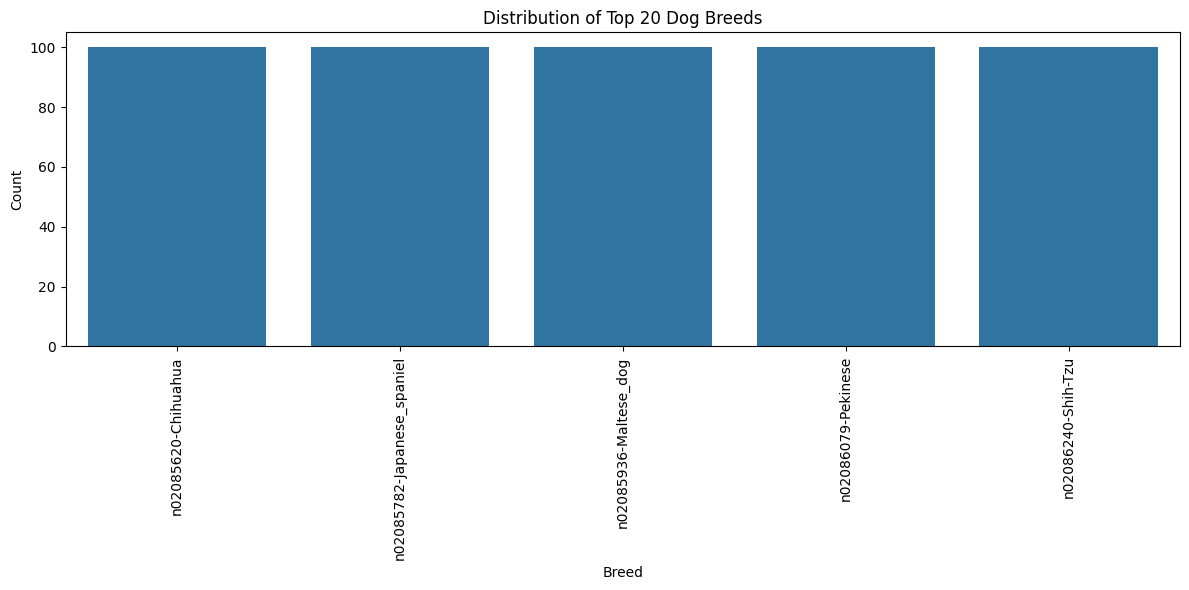

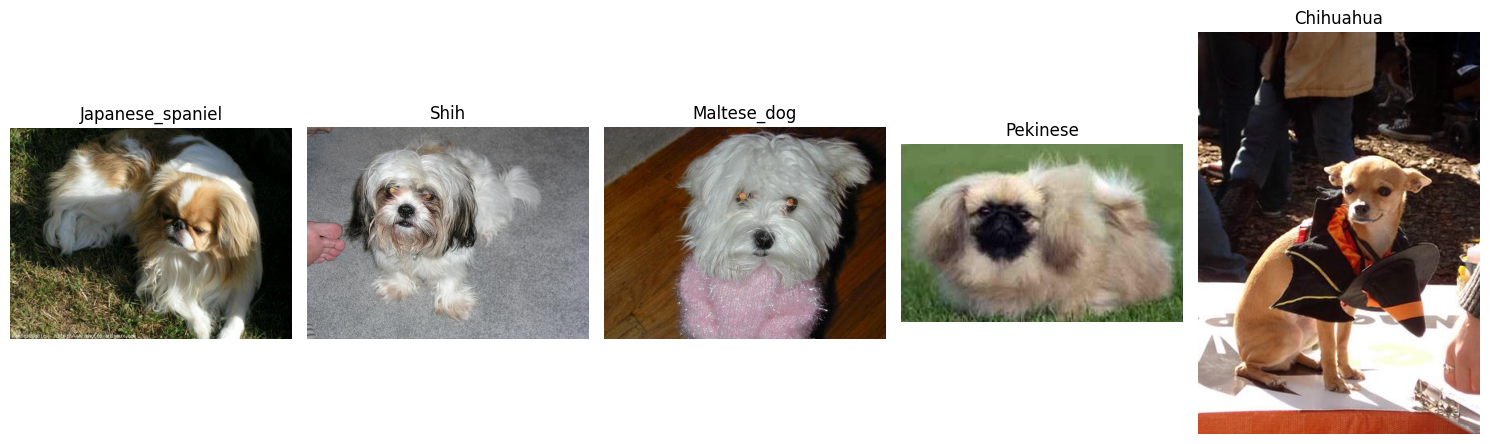

In [143]:
#Dataset Exploration
def load_train_test_lists(train_path, test_path):
    """Load train and test lists from .mat files"""
    
    # Load .mat files
    train_data = scipy.io.loadmat(train_path)
    test_data = scipy.io.loadmat(test_path)
    
    # Print keys
    print("Train data keys:", train_data.keys())
    print("Test data keys:", test_data.keys())
    
    # Extract file lists
    train_files = [str(file[0]) for file in train_data["file_list"]]
    test_files = [str(file[0]) for file in test_data["file_list"]]
    
    # Clean up file paths (remove extra quotes and brackets)
    train_files = [path.strip("[]'") for path in train_files]
    test_files = [path.strip("[]'") for path in test_files]
    
    print(f"✅ Loaded {len(train_files)} training files and {len(test_files)} test files")
    
    return train_files, test_files

def explore_dataset(image_dir, file_list):
    """Explore the dataset and show statistics"""
    
    # Get breed names
    breeds = [path.split('/')[0] for path in file_list]
    breed_counts = pd.Series(breeds).value_counts()
    
    # Print statistics
    print(f"Total images: {len(file_list)}")
    print(f"Number of breeds: {len(breed_counts)}")
    print(f"Average images per breed: {breed_counts.mean():.1f}")
    print(f"Min images for a breed: {breed_counts.min()} ({breed_counts.idxmin()})")
    print(f"Max images for a breed: {breed_counts.max()} ({breed_counts.idxmax()})")
    
    # Plot breed distribution
    plt.figure(figsize=(12, 6))
    top_breeds = breed_counts.head(20)
    sns.barplot(x=top_breeds.index, y=top_breeds.values)
    plt.xticks(rotation=90)
    plt.title("Distribution of Top 20 Dog Breeds")
    plt.xlabel("Breed")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    return breed_counts

def show_sample_images(image_dir, file_list, num_samples=5):
    """Show sample images from different breeds"""
    
    # Get unique breeds
    breeds = list(set([path.split('/')[0] for path in file_list]))
    
    # Sample some breeds
    sampled_breeds = np.random.choice(breeds, min(num_samples, len(breeds)), replace=False)
    
    # Create a figure
    fig, axes = plt.subplots(1, len(sampled_breeds), figsize=(15, 5))
    
    for i, breed in enumerate(sampled_breeds):
        # Get all images for this breed
        breed_files = [f for f in file_list if f.startswith(breed)]
        
        # Pick a random image
        img_path = os.path.join(image_dir, np.random.choice(breed_files))
        
        # Load and display
        img = Image.open(img_path).convert("RGB")
        axes[i].imshow(img)
        
        # Clean up breed name for display
        breed_name = breed.split('-')[1] if '-' in breed else breed
        axes[i].set_title(breed_name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load train and test lists
train_files, test_files = load_train_test_lists(train_list_path, test_list_path)

# If running on CPU with limited resources, use a subset
if device.type == "cpu":
    print("⚠️ Running on CPU, using subset of data for quicker processing")
    train_files = train_files[:500]
    test_files = test_files[:100]

# Explore dataset
breed_counts = explore_dataset(image_dir, train_files)

# Show sample images
show_sample_images(image_dir, train_files)

In [144]:
# Cell 7: Dataset Class Definition
class DogBreedDataset(Dataset):
    """
    PyTorch Dataset for loading dog breed images
    
    This dataset handles:
    - Loading images from the filesystem
    - Converting to RGB
    - Applying transformations
    - Converting breed names to numeric labels
    """
    def __init__(self, file_list, image_folder, transform=None):
        """
        Initialize the dataset
        
        Args:
            file_list: List of image file paths (relative to image_folder)
            image_folder: Root folder containing all images
            transform: PyTorch transforms to apply to images
        """
        self.file_list = file_list
        self.image_folder = image_folder
        self.transform = transform
        
        # Extract all unique breed names
        self.breeds = sorted(set([path.split('/')[0] for path in file_list]))
        self.breed_to_idx = {breed: idx for idx, breed in enumerate(self.breeds)}
        
        # Check if any files are missing
        self._validate_files()
    
    def _validate_files(self):
        """Check if all files in the list exist"""
        missing_files = 0
        for file_path in self.file_list[:100]:  # Check first 100 files only
            full_path = os.path.join(self.image_folder, file_path)
            if not os.path.exists(full_path):
                missing_files += 1
        
        if missing_files > 0:
            print(f"⚠️ Warning: {missing_files} files not found in the first 100 files checked.")
    
    def __len__(self):
        """Return the number of images in the dataset"""
        return len(self.file_list)
    
    def __getitem__(self, idx):
        """
        Get an image and its label by index
        
        Args:
            idx: Index of the item to get
            
        Returns:
            tuple: (image_tensor, label_index)
        """
        # Get file path
        file_path = self.file_list[idx]
        full_path = os.path.join(self.image_folder, file_path)
        
        try:
            # Load image
            image = Image.open(full_path).convert("RGB")
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            
            # Get label
            breed = file_path.split('/')[0]
            label = self.breed_to_idx[breed]
            
            return image, label
            
        except Exception as e:
            print(f"⚠️ Error loading {full_path}: {str(e)}")
            # Return a placeholder
            if self.transform:
                placeholder = torch.zeros((3, 224, 224))
                return placeholder, 0
            else:
                placeholder = Image.new('RGB', (224, 224), color='gray')
                return placeholder, 0
    
    def get_breed_counts(self):
        """Get the count of images for each breed"""
        breed_counts = {}
        for file_path in self.file_list:
            breed = file_path.split('/')[0]
            if breed in breed_counts:
                breed_counts[breed] += 1
            else:
                breed_counts[breed] = 1
        
        return breed_counts
    
    @staticmethod
    def format_breed_name(breed):
        """Format a breed name for display (remove prefix, replace hyphens)"""
        if '-' in breed:
            # Remove prefix like 'n02085620-'
            parts = breed.split('-')
            return parts[1].replace('_', ' ').title()
        else:
            return breed.replace('_', ' ').title()
    
    def get_formatted_breeds(self):
        """Get a list of formatted breed names"""
        return [self.format_breed_name(breed) for breed in self.breeds]

## 🔄 Data Processing

Now we'll define the transformations for our images and create our datasets.

✅ Created datasets with 500 training samples and 100 test samples
✅ Using 5 breed classes


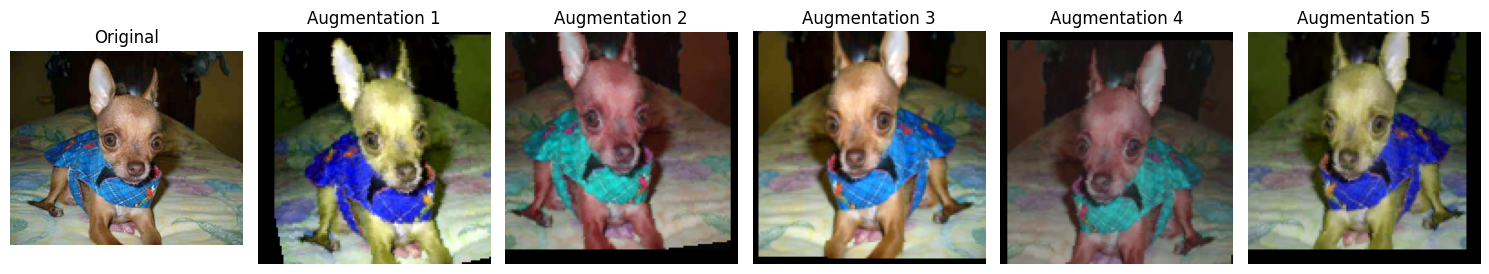

In [145]:
# Define Transforms and Create Datasets
def create_transforms(image_size, use_augmentation):
    """
    Create transformation pipelines for training and validation
    
    Args:
        image_size: Image size (tuple of height, width)
        use_augmentation: Whether to use data augmentation
    
    Returns:
        tuple: (train_transform, valid_transform)
    """
    # Always apply the same validation transform
    valid_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Training transform with or without augmentation
    if use_augmentation:
        train_transform = transforms.Compose([
            transforms.Resize((int(image_size[0] * 1.1), int(image_size[1] * 1.1))),
            transforms.RandomRotation(15),
            transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        # No augmentation, use same as validation
        train_transform = valid_transform
    
    return train_transform, valid_transform

def show_augmentations(image_path, transform, num_samples=5):
    """Show multiple augmented versions of the same image"""
    # Load image
    original_img = Image.open(image_path).convert("RGB")
    
    # Create augmented versions
    augmented_imgs = []
    for _ in range(num_samples):
        # Apply transform
        augmented_img = transform(original_img)
        
        # Convert tensor to numpy for visualization
        img_np = augmented_img.permute(1, 2, 0).numpy()
        
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        augmented_imgs.append(img_np)
    
    # Display
    fig, axes = plt.subplots(1, num_samples + 1, figsize=(15, 5))
    
    # Original
    axes[0].imshow(original_img)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Augmented
    for i, img_np in enumerate(augmented_imgs):
        axes[i+1].imshow(img_np)
        axes[i+1].set_title(f"Augmentation {i+1}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create transforms
train_transform, valid_transform = create_transforms(
    image_size=config.image_size,
    use_augmentation=config.use_augmentation
)

# Create datasets
train_dataset = DogBreedDataset(train_files, image_dir, transform=train_transform)
test_dataset = DogBreedDataset(test_files, image_dir, transform=valid_transform)

print(f"✅ Created datasets with {len(train_dataset)} training samples and {len(test_dataset)} test samples")

# Get breed labels
breed_labels = train_dataset.breeds
print(f"✅ Using {len(breed_labels)} breed classes")

# Show data augmentations (if images are available)
try:
    # Get a sample image path
    sample_file = train_files[0]
    sample_path = os.path.join(image_dir, sample_file)
    
    # Show augmentations
    show_augmentations(sample_path, train_transform)
except Exception as e:
    print(f"Could not show augmentations: {str(e)}")

In [146]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=4 if config.device.type == "cuda" else 0,
    pin_memory=True if config.device.type == "cuda" else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4 if config.device.type == "cuda" else 0,
    pin_memory=True if config.device.type == "cuda" else False
)

print(f"✅ Created DataLoaders with batch size {config.batch_size}")
print(f"✅ Training will use {len(train_loader)} batches per epoch")

✅ Created DataLoaders with batch size 8
✅ Training will use 63 batches per epoch


## 🧠 Model Architecture

Now we'll define our model architecture using transfer learning with pretrained backbones.

In [147]:
# Model Architecture
class DogBreedClassifier(nn.Module):
    """
    Dog breed classifier using transfer learning with various backbone options.
    
    This model allows for multiple backbone architectures and customization
    options for fine-tuning and feature extraction.
    """
    def __init__(self, num_classes, backbone="efficientnet", dropout_rate=0.3, freeze_backbone=False):
        """
        Initialize the model with the specified backbone and parameters.
        
        Args:
            num_classes (int): Number of dog breed classes to classify
            backbone (str): Which backbone architecture to use ["resnet50", "mobilenetv2", "efficientnet"]
            dropout_rate (float): Dropout rate for regularization (0-1)
            freeze_backbone (bool): Whether to freeze the backbone weights during training
        """
        super(DogBreedClassifier, self).__init__()
        
        self.backbone_name = backbone
        self.dropout_rate = dropout_rate
        
        # Initialize the backbone architecture
        if backbone == "resnet50":
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # Remove classifier
            
        elif backbone == "mobilenetv2":
            self.backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
            self.feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()  # Remove classifier
            
        elif backbone == "efficientnet":
            self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
            self.feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()  # Remove classifier
            
        else:
            raise ValueError(f"Unsupported backbone: {backbone}. Choose from: resnet50, mobilenetv2, efficientnet")
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),  # Lower dropout in final layers
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        """Forward pass through the model"""
        features = self.backbone(x)
        return self.classifier(features)
    
    def get_model_size(self):
        """Calculate model size in MB"""
        param_size = 0
        for param in self.parameters():
            param_size += param.nelement() * param.element_size()
        buffer_size = 0
        for buffer in self.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()
        return (param_size + buffer_size) / (1024 * 1024)
    
    def get_parameter_count(self):
        """Return the total number of parameters"""
        return sum(p.numel() for p in self.parameters())

# Create model
model = DogBreedClassifier(
    num_classes=len(breed_labels),
    backbone=config.backbone,
    dropout_rate=config.dropout_rate,
    freeze_backbone=config.freeze_backbone
)
model = model.to(config.device)

# Print model info
print(f"📊 Model Architecture: {config.backbone}")
print(f"📊 Total Parameters: {model.get_parameter_count():,}")
print(f"📊 Model Size: {model.get_model_size():.2f} MB")

📊 Model Architecture: efficientnet
📊 Total Parameters: 4,665,985
📊 Model Size: 17.96 MB


## 🏋️‍♀️ Training Utilities

Let's define the utilities for training, logging, and evaluation.

In [148]:
# Cell 11: Training and Experiment Utilities

# Markdown cell:
"""
## 🏋️‍♀️ Training and Experiment Utilities

Let's define the utilities for training, evaluation, and experiment tracking.
"""

class TrainingLogger:
    """
    Logger for tracking and visualizing training progress.
    
    This class handles:
    - Per-epoch metrics tracking
    - CSV logging
    - Training progress visualization
    - Model checkpointing
    """
    def __init__(self, log_dir="logs"):
        """
        Initialize the training logger.
        
        Args:
            log_dir: Directory to save logs and checkpoints
        """
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(os.path.join(log_dir, "checkpoints"), exist_ok=True)
        
        # Initialize tracking variables
        self.run_id = int(datetime.now().timestamp())
        self.start_time = time.time()
        self.epoch_times = []
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.learning_rates = []
        
        # Create log CSV files with headers
        self.metrics_file = os.path.join(log_dir, f"metrics_{self.run_id}.csv")
        with open(self.metrics_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'val_loss', 'val_accuracy', 'learning_rate', 'time_seconds'])
    
    def log_epoch(self, epoch, train_loss, val_loss, val_accuracy, learning_rate, epoch_time):
        """Log metrics for a completed epoch"""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_accuracy)
        self.learning_rates.append(learning_rate)
        self.epoch_times.append(epoch_time)
        
        # Append to CSV
        with open(self.metrics_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, val_loss, val_accuracy, learning_rate, epoch_time])
    
    def save_checkpoint(self, model, optimizer, epoch, val_accuracy):
        """Save model checkpoint"""
        checkpoint_path = os.path.join(self.log_dir, "checkpoints", f"epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'train_loss': self.train_losses[-1] if self.train_losses else None,
            'val_loss': self.val_losses[-1] if self.val_losses else None,
        }, checkpoint_path)
        
        # Save best model separately
        if val_accuracy == max(self.val_accuracies):
            best_path = os.path.join(self.log_dir, "best_model.pt")
            torch.save(model.state_dict(), best_path)
            print(f"✅ New best model saved! Accuracy: {val_accuracy:.2f}%")
    
    def plot_metrics(self, figsize=(15, 10)):
        """Plot training metrics"""
        if not self.train_losses:
            print("No training data to plot yet.")
            return
            
        epochs = list(range(1, len(self.train_losses) + 1))
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot training and validation loss
        axes[0, 0].plot(epochs, self.train_losses, 'b-', label='Training Loss')
        if self.val_losses:
            axes[0, 0].plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        axes[0, 0].set_title('Loss vs. Epochs')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot validation accuracy
        if self.val_accuracies:
            axes[0, 1].plot(epochs, self.val_accuracies, 'g-')
            axes[0, 1].set_title('Validation Accuracy vs. Epochs')
            axes[0, 1].set_xlabel('Epochs')
            axes[0, 1].set_ylabel('Accuracy (%)')
            axes[0, 1].grid(True)
        
        # Plot learning rate
        axes[1, 0].plot(epochs, self.learning_rates, 'm-')
        axes[1, 0].set_title('Learning Rate vs. Epochs')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].grid(True)
        
        # Plot epoch times
        axes[1, 1].plot(epochs, self.epoch_times, 'c-')
        axes[1, 1].set_title('Epoch Time vs. Epochs')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Time (seconds)')
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.log_dir, f"training_metrics_{self.run_id}.png"))
        plt.show()
    
    def plot_confusion_matrix(self, true_labels, predictions, class_names, figsize=(12, 10)):
        """Plot confusion matrix of model predictions"""
        cm = confusion_matrix(true_labels, predictions)
        
        # Normalize the confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=figsize)
        sns.heatmap(cm_norm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Normalized Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(self.log_dir, f"confusion_matrix_{self.run_id}.png"))
        plt.show()
    
    def summary(self):
        """Print training summary"""
        if not self.train_losses:
            print("No training has been logged yet.")
            return
            
        total_time = time.time() - self.start_time
        total_epochs = len(self.train_losses)
        
        print("=" * 50)
        print(f"📊 TRAINING SUMMARY (Run ID: {self.run_id})")
        print("=" * 50)
        print(f"Total training time: {total_time/60:.2f} minutes")
        print(f"Total epochs: {total_epochs}")
        print(f"Average epoch time: {sum(self.epoch_times)/len(self.epoch_times):.2f} seconds")
        print(f"Best validation accuracy: {max(self.val_accuracies):.2f}%")
        print(f"Final validation accuracy: {self.val_accuracies[-1]:.2f}%")
        print(f"Final training loss: {self.train_losses[-1]:.4f}")
        print(f"Final validation loss: {self.val_losses[-1]:.4f}")
        print("=" * 50)

    def log_epoch(self, epoch, train_loss, val_loss, val_accuracy, learning_rate, epoch_time):
        """Log metrics for a completed epoch"""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_accuracy)
        self.learning_rates.append(learning_rate)
        self.epoch_times.append(epoch_time)
        
        # Append to CSV
        with open(self.metrics_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, val_loss, val_accuracy, learning_rate, epoch_time])
        
        # ADDED: Log to epoch_loss.csv for backwards compatibility
        self.log_to_epoch_loss_csv(epoch, train_loss)
    
    def log_to_epoch_loss_csv(self, epoch, loss):
        """Log epoch loss to the legacy epoch_loss.csv file"""
        epoch_loss_file = os.path.join(config.experiments_dir, "epoch_loss.csv")
        file_exists = os.path.isfile(epoch_loss_file)
        
        with open(epoch_loss_file, 'a', newline='') as f:
            writer = csv.writer(f)
            if not file_exists:
                writer.writerow(['run_id', 'epoch', 'loss'])
            writer.writerow([self.run_id, epoch, loss])

def log_run_to_csv(config, model, accuracy, train_time, logger, csv_path=None):
    """
    Log experiment results to CSV for comparison across different runs
    
    Args:
        config: Configuration object with experiment settings
        model: Trained model
        accuracy: Final accuracy achieved
        train_time: Total training time in seconds
        logger: TrainingLogger instance
        csv_path: Path to CSV file for saving results
    """
        
    if csv_path is None:
        csv_path = config.experiment_csv

    print(f"Saving experiment data to: {csv_path}")
    
    # Create experiments directory if it doesn't exist
    directory = os.path.dirname(csv_path)
    if directory:  # Only create if there's actually a directory path
        os.makedirs(directory, exist_ok=True)
        print(f"Ensuring directory exists: {directory}")
        
    # Create run info dictionary
    run_info = {
        # Run identifiers
        "run_id": logger.run_id,
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M"),
        "experiment_name": config.experiment_name,
        
        # Model architecture
        "backbone": config.backbone,
        "dropout_rate": config.dropout_rate,
        "freeze_backbone": config.freeze_backbone,
        
        # Learning rate settings
        "lr_strategy": config.lr_strategy,
        "fixed_lr": config.fixed_lr if config.lr_strategy == "fixed" else None,
        "cyclic_base_lr": config.cyclic_base_lr if config.lr_strategy == "cyclic" else None,
        "cyclic_max_lr": config.cyclic_max_lr if config.lr_strategy == "cyclic" else None,
        
        # Training settings
        "epochs": config.num_epochs,
        "batch_size": config.batch_size,
        "image_size": f"{config.image_size[0]}x{config.image_size[1]}",
        "augmentation": "Yes" if config.use_augmentation else "No",
        "device": str(config.device),
        
        # Performance metrics
        "final_accuracy": round(accuracy, 2),
        "best_accuracy": round(max(logger.val_accuracies), 2),
        "final_train_loss": round(logger.train_losses[-1], 4),
        "final_val_loss": round(logger.val_losses[-1], 4),
        "total_train_time_min": round(train_time / 60, 2),
        "avg_epoch_time_sec": round(sum(logger.epoch_times) / len(logger.epoch_times), 2),
        
        # Model metrics
        "model_size_mb": round(model.get_model_size(), 2),
        "total_params": model.get_parameter_count()
    }
    
    # Check if file exists
    file_exists = os.path.isfile(csv_path)
    
    # Write to CSV
    with open(csv_path, mode="a", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=run_info.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(run_info)
    
    print(f"✅ Run info logged to: {csv_path}")
    
    # Also save per-epoch metrics to a separate CSV for learning curves
    epoch_data = {
        "run_id": [logger.run_id] * len(logger.train_losses),
        "experiment_name": [config.experiment_name] * len(logger.train_losses),
        "backbone": [config.backbone] * len(logger.train_losses),
        "epoch": list(range(1, len(logger.train_losses) + 1)),
        "train_loss": logger.train_losses,
        "val_loss": logger.val_losses,
        "val_accuracy": logger.val_accuracies,
        "learning_rate": logger.learning_rates,
        "epoch_time": logger.epoch_times
    }
    
    # Make sure the experiments directory exists for epoch metrics
    if hasattr(config, 'experiments_dir'):
        experiments_dir = config.experiments_dir
    else:
        experiments_dir = "experiments"
        os.makedirs(experiments_dir, exist_ok=True)
    
    # Save detailed epoch metrics
    epoch_csv_path = os.path.join(experiments_dir, f"epoch_metrics_{logger.run_id}.csv")
    pd.DataFrame(epoch_data).to_csv(epoch_csv_path, index=False)
    print(f"✅ Epoch metrics saved to: {epoch_csv_path}")
    
    # Also save to the legacy epoch_loss.csv in the experiments directory
    epoch_loss_path = os.path.join(experiments_dir, "epoch_loss.csv")
    loss_file_exists = os.path.isfile(epoch_loss_path)
    
    with open(epoch_loss_path, 'a', newline='') as f:
        writer = csv.writer(f)
        if not loss_file_exists:
            writer.writerow(['run_id', 'epoch', 'loss'])
        
        # Add a row for each epoch
        for epoch, loss in enumerate(logger.train_losses, 1):
            writer.writerow([logger.run_id, epoch, loss])
    
    print(f"✅ Legacy epoch loss data saved to: {epoch_loss_path}")

def compare_runs(csv_path=None):
    """
    Compare metrics across different training runs
    """
    # Use config's experiment_csv if no path provided
    if csv_path is None:
        if hasattr(config, 'experiment_csv'):
            csv_path = config.experiment_csv
        else:
            csv_path = "experiments/training_runs_v4.csv"

    # Load the CSV
    if not os.path.exists(csv_path):
        print(f"No run data found at {csv_path}")
        return
        
    runs_df = pd.read_csv(csv_path)
    
    if len(runs_df) < 2:
        print("Need at least 2 runs to compare")
        return
    
    # Display the comparison table
    print("\n📊 COMPARISON OF TRAINING RUNS")
    print("=" * 100)
    
    # Select key columns to display, now including device
    display_cols = ["run_id", "backbone", "final_accuracy", "model_size_mb", 
                   "total_train_time_min", "augmentation", "lr_strategy", "device", "epochs"]
    
    # Show the data
    display(runs_df[display_cols].sort_values("final_accuracy", ascending=False))
    
    # Plot comparisons
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy by backbone
    sns.barplot(x="backbone", y="final_accuracy", hue="device", data=runs_df, ax=axes[0, 0])
    axes[0, 0].set_title("Accuracy by Backbone (GPU vs CPU)")
    axes[0, 0].set_ylabel("Accuracy (%)")
    
    # Training time by backbone
    sns.barplot(x="backbone", y="total_train_time_min", hue="device", data=runs_df, ax=axes[0, 1])
    axes[0, 1].set_title("Training Time by Backbone (GPU vs CPU)")
    axes[0, 1].set_ylabel("Time (minutes)")
    
    # Model size by backbone
    sns.barplot(x="backbone", y="model_size_mb", hue="device", data=runs_df, ax=axes[1, 0])
    axes[1, 0].set_title("Model Size by Backbone")
    axes[1, 0].set_ylabel("Size (MB)")
    
    # Accuracy vs Model Size scatter plot
    sns.scatterplot(x="model_size_mb", y="final_accuracy", hue="backbone", 
                    style="device", size="total_train_time_min", sizes=(50, 200), 
                    data=runs_df, ax=axes[1, 1])
    axes[1, 1].set_title("Accuracy vs. Model Size")
    axes[1, 1].set_xlabel("Model Size (MB)")
    axes[1, 1].set_ylabel("Accuracy (%)")
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Device comparison
    plt.figure(figsize=(10, 6))
    device_grouped = runs_df.groupby(['device', 'backbone']).agg({
        'final_accuracy': 'mean',
        'total_train_time_min': 'mean'
    }).reset_index()
    
    sns.barplot(x='backbone', y='total_train_time_min', hue='device', data=device_grouped)
    plt.title('Average Training Time by Device and Backbone')
    plt.ylabel('Training Time (minutes)')
    plt.xlabel('Backbone Architecture')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Create a figure to visualize learning curves if epoch data is available
    try:
        # See if any epoch data files exist
        epoch_files = [f for f in os.listdir() if f.startswith("epoch_metrics_") and f.endswith(".csv")]
        if not epoch_files:
            return
            
        # Combine epoch data from different runs
        all_epochs_df = pd.concat([pd.read_csv(f) for f in epoch_files])
        
        # Merge with run metadata
        runs_df_simple = runs_df[["run_id", "backbone", "experiment_name", "device"]]
        merged_df = pd.merge(all_epochs_df, runs_df_simple, on="run_id")
        
        # Plot learning curves
        plt.figure(figsize=(12, 8))
        sns.lineplot(x="epoch", y="val_accuracy", hue="experiment_name", 
                    style="device", data=merged_df)
        plt.title("Validation Accuracy Across Runs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"Could not plot learning curves: {e}")

def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    """
    Train for one epoch
    
    Args:
        model: PyTorch model
        train_loader: DataLoader for training set
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler (can be None)
        device: Device to train on (cpu/cuda)
        
    Returns:
        average_loss: Average loss over the epoch
    """
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update learning rate if using scheduler
        if scheduler is not None:
            scheduler.step()
        
        # Update statistics
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    # Calculate average loss
    average_loss = running_loss / len(train_loader)
    
    return average_loss

def validate(model, val_loader, criterion, device):
    """
    Validate the model
    
    Args:
        model: PyTorch model
        val_loader: DataLoader for validation set
        criterion: Loss function
        device: Device to validate on (cpu/cuda)
        
    Returns:
        tuple: (validation_loss, accuracy)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(val_loader, desc="Validating")
    
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            accuracy = 100 * correct / total
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{accuracy:.2f}%"})
    
    # Calculate metrics
    validation_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    
    return validation_loss, accuracy

def get_current_lr(optimizer):
    """Get the current learning rate from the optimizer"""
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def visualize_epoch_loss_history(epoch_loss_csv="epoch_loss.csv", run_info_csv="training_runs_v4.csv"):
    """
    Visualize epoch loss history across different runs
    
    Args:
        epoch_loss_csv: Path to the epoch loss CSV file
        run_info_csv: Path to the run information CSV file
    """

    # Set default paths if not provided
    if epoch_loss_csv is None:
        if hasattr(config, 'experiments_dir'):
            epoch_loss_csv = os.path.join(config.experiments_dir, "epoch_loss.csv")
        else:
            epoch_loss_csv = "experiments/epoch_loss.csv"
    
    if run_info_csv is None:
        if hasattr(config, 'experiment_csv'):
            run_info_csv = config.experiment_csv
        else:
            run_info_csv = "experiments/training_runs_v4.csv"
    
    # Check if files exist
    if not os.path.exists(epoch_loss_csv):
        print(f"Error visualizing epoch loss: File not found at {epoch_loss_csv}")
        return
        
    if not os.path.exists(run_info_csv):
        print(f"Error visualizing epoch loss: Run info file not found at {run_info_csv}")
        return

    try:
        # Load the data
        loss_df = pd.read_csv(epoch_loss_csv)
        runs_df = pd.read_csv(run_info_csv)
        
        # Merge to get run metadata
        runs_df_subset = runs_df[['run_id', 'backbone', 'lr_strategy', 'device', 'experiment_name']]
        merged_df = pd.merge(loss_df, runs_df_subset, on='run_id', how='left')
        
        # Plot loss curves by run
        plt.figure(figsize=(12, 8))
        sns.lineplot(data=merged_df, x='epoch', y='loss', hue='experiment_name', style='backbone')
        plt.title('Training Loss by Epoch Across Runs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Plot comparison by backbone
        plt.figure(figsize=(12, 8))
        sns.lineplot(data=merged_df, x='epoch', y='loss', hue='backbone', style='device')
        plt.title('Training Loss by Backbone and Device')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Show final loss statistics
        print("\n📊 Final Epoch Loss by Run:")
        last_epochs = merged_df.groupby('run_id').apply(lambda x: x.nlargest(1, 'epoch')).reset_index(drop=True)
        display(last_epochs[['run_id', 'experiment_name', 'backbone', 'epoch', 'loss']].sort_values('loss'))
        
    except Exception as e:
        print(f"Error visualizing epoch loss: {str(e)}")

## 🚀 Training Process

Now we'll train the model using the configured settings.

🔄 Using Cyclic LR: 1e-05 → 5e-05 (step size: 340)

📌 Epoch 1/3


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

📊 Train Loss: 1.6036, Val Loss: 1.5690, Val Accuracy: 39.00%, Time: 33.76s
✅ New best model saved! Accuracy: 39.00%


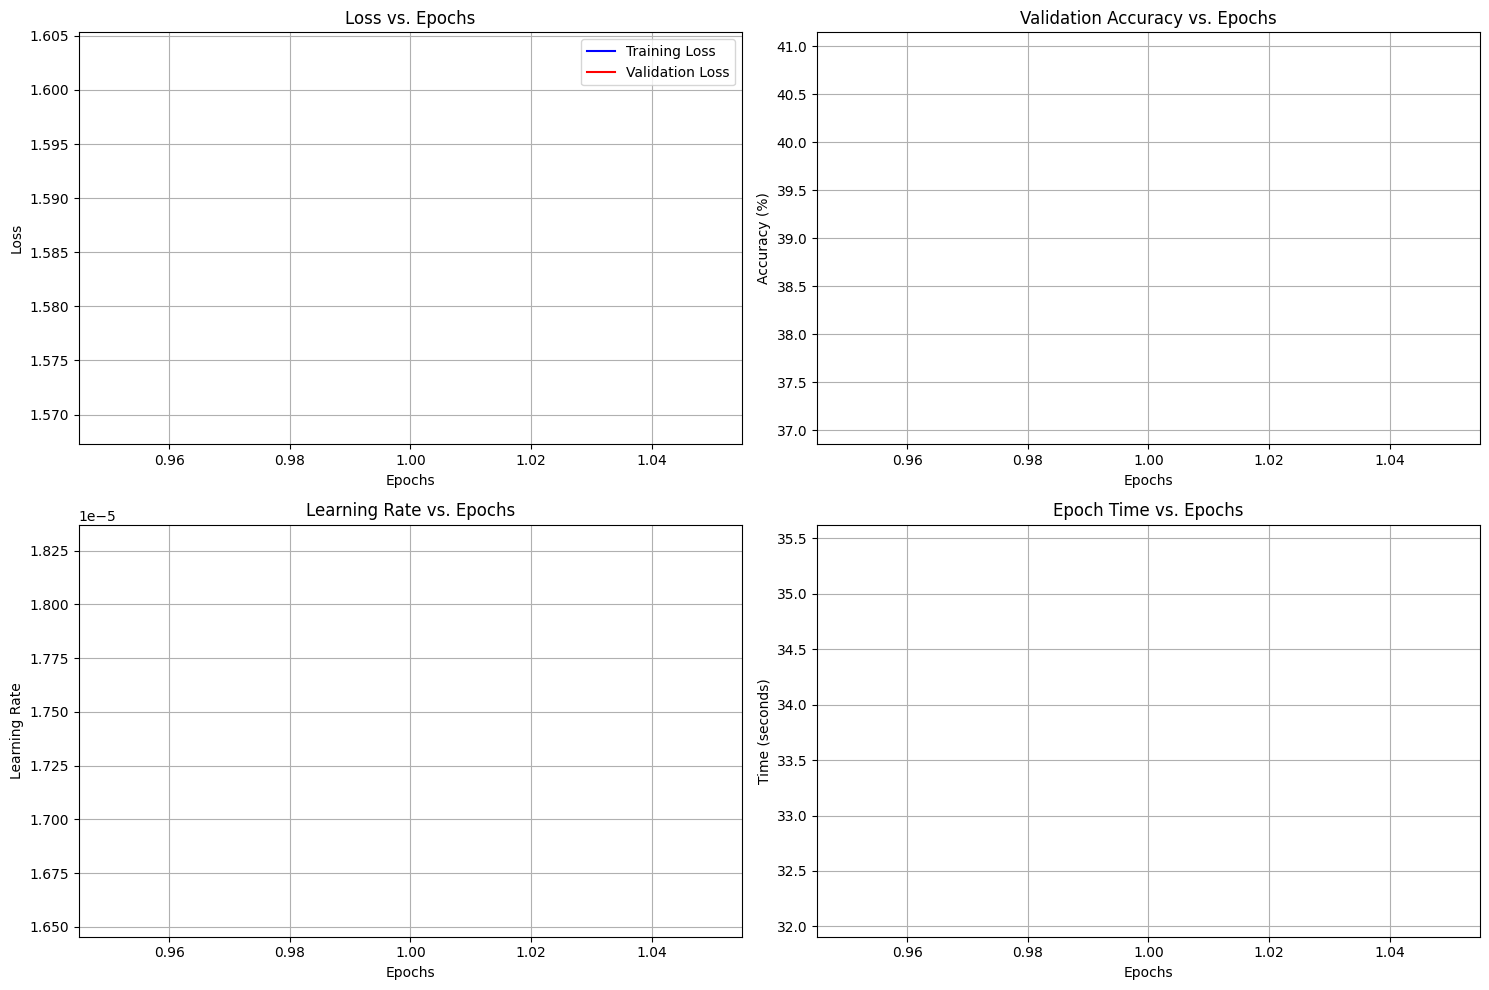


📌 Epoch 2/3


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

📊 Train Loss: 1.5742, Val Loss: 1.5303, Val Accuracy: 60.00%, Time: 35.52s
✅ New best model saved! Accuracy: 60.00%


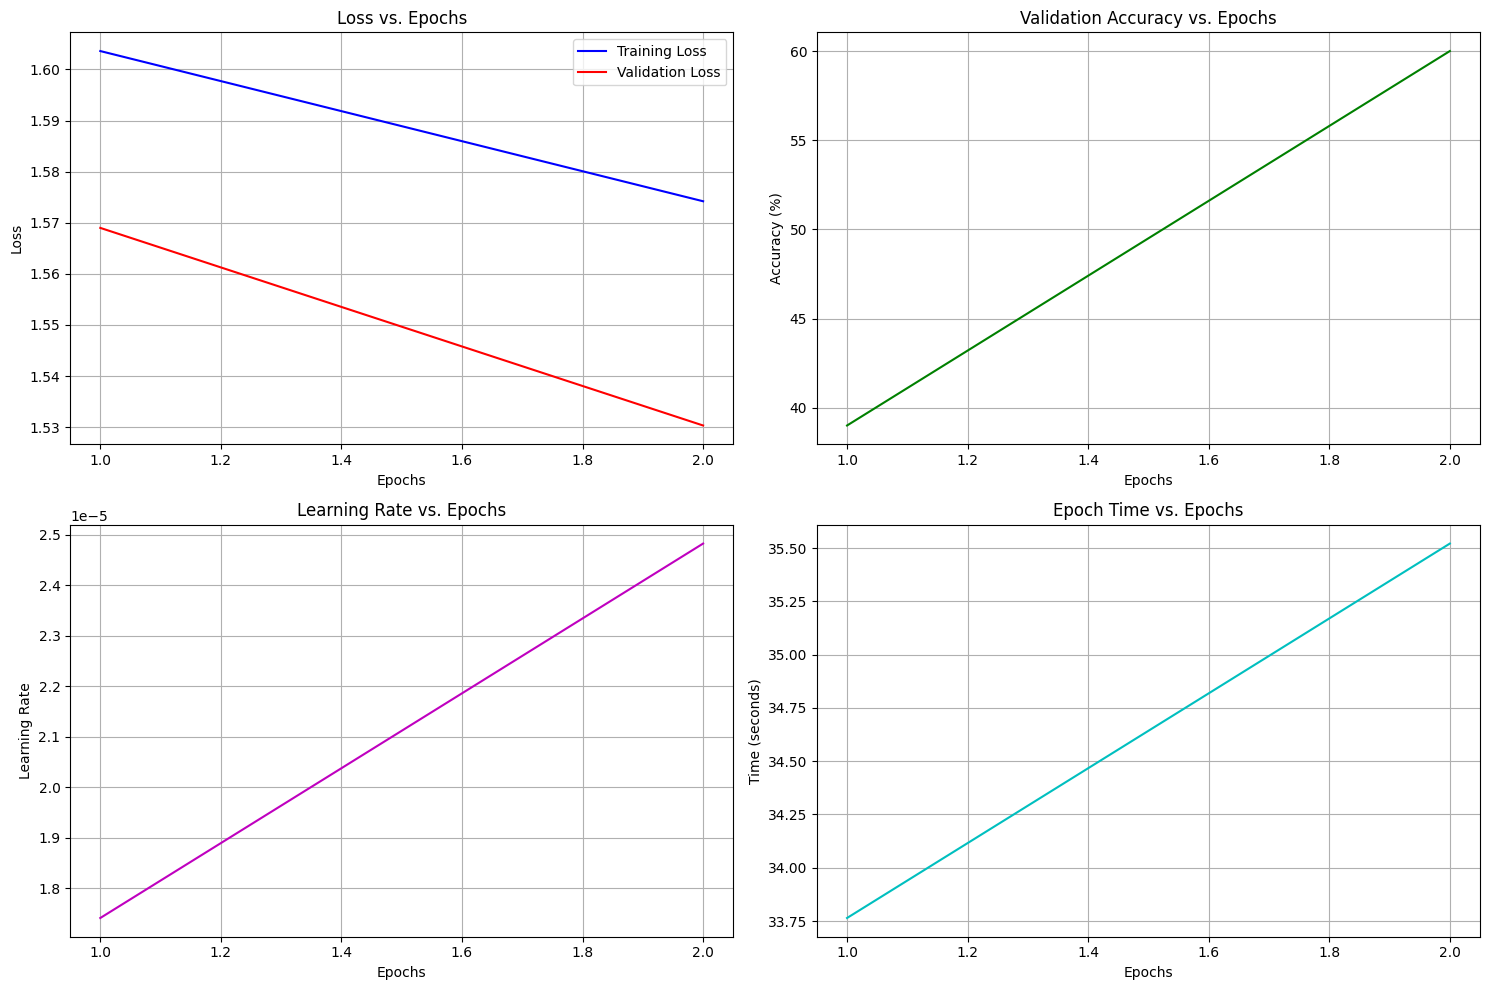


📌 Epoch 3/3


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

📊 Train Loss: 1.5120, Val Loss: 1.4314, Val Accuracy: 81.00%, Time: 36.50s
✅ New best model saved! Accuracy: 81.00%


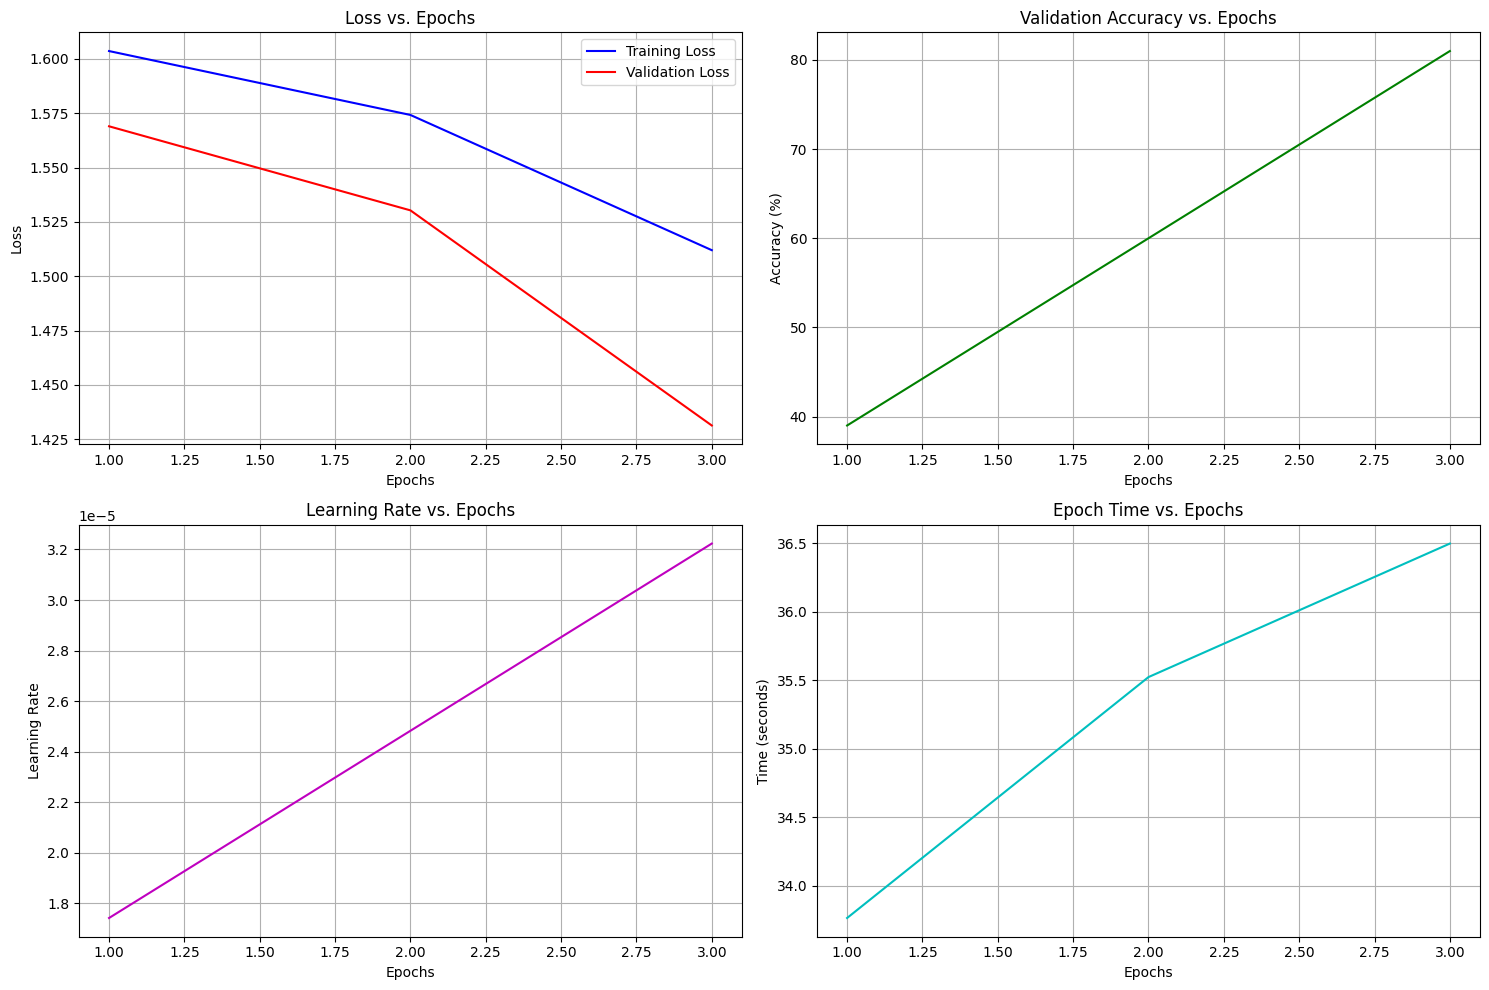


✅ Training completed in 1.86 minutes
✅ Best validation accuracy: 81.00%


In [149]:
# Training Loop
# Create criterion, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                      lr=(config.fixed_lr if config.lr_strategy == "fixed" 
                         else config.cyclic_max_lr))

if config.lr_strategy == "cyclic":
    print(f"🔄 Using Cyclic LR: {config.cyclic_base_lr} → {config.cyclic_max_lr} (step size: {config.cyclic_step_size})")
    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=config.cyclic_base_lr,
        max_lr=config.cyclic_max_lr,
        step_size_up=config.cyclic_step_size,
        mode='triangular2',
        cycle_momentum=False
    )
else:
    print(f"📊 Using fixed learning rate: {config.fixed_lr}")
    scheduler = None

# Create training logger
logger = TrainingLogger(os.path.join(config.log_dir, config.experiment_name))

# Training loop
best_accuracy = 0.0
total_start_time = time.time()

for epoch in range(1, config.num_epochs + 1):
    print(f"\n📌 Epoch {epoch}/{config.num_epochs}")
    
    # Training phase
    epoch_start_time = time.time()
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, config.device)
    
    # Validation phase
    val_loss, val_accuracy = validate(model, test_loader, criterion, config.device)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    
    # Get current learning rate
    current_lr = get_current_lr(optimizer)
    
    # Log metrics
    logger.log_epoch(epoch, train_loss, val_loss, val_accuracy, current_lr, epoch_time)
    
    # Print epoch summary
    print(f"📊 Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_time:.2f}s")
    
    # Save checkpoint if best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        logger.save_checkpoint(model, optimizer, epoch, val_accuracy)
    
    # Visualize progress every few epochs
    if epoch % max(1, config.num_epochs // 5) == 0 or epoch == config.num_epochs:
        logger.plot_metrics()

# Print total training time
total_training_time = time.time() - total_start_time
print(f"\n✅ Training completed in {total_training_time/60:.2f} minutes")
print(f"✅ Best validation accuracy: {best_accuracy:.2f}%")

## 📊 Results Visualization

Let's visualize the training results and model performance.

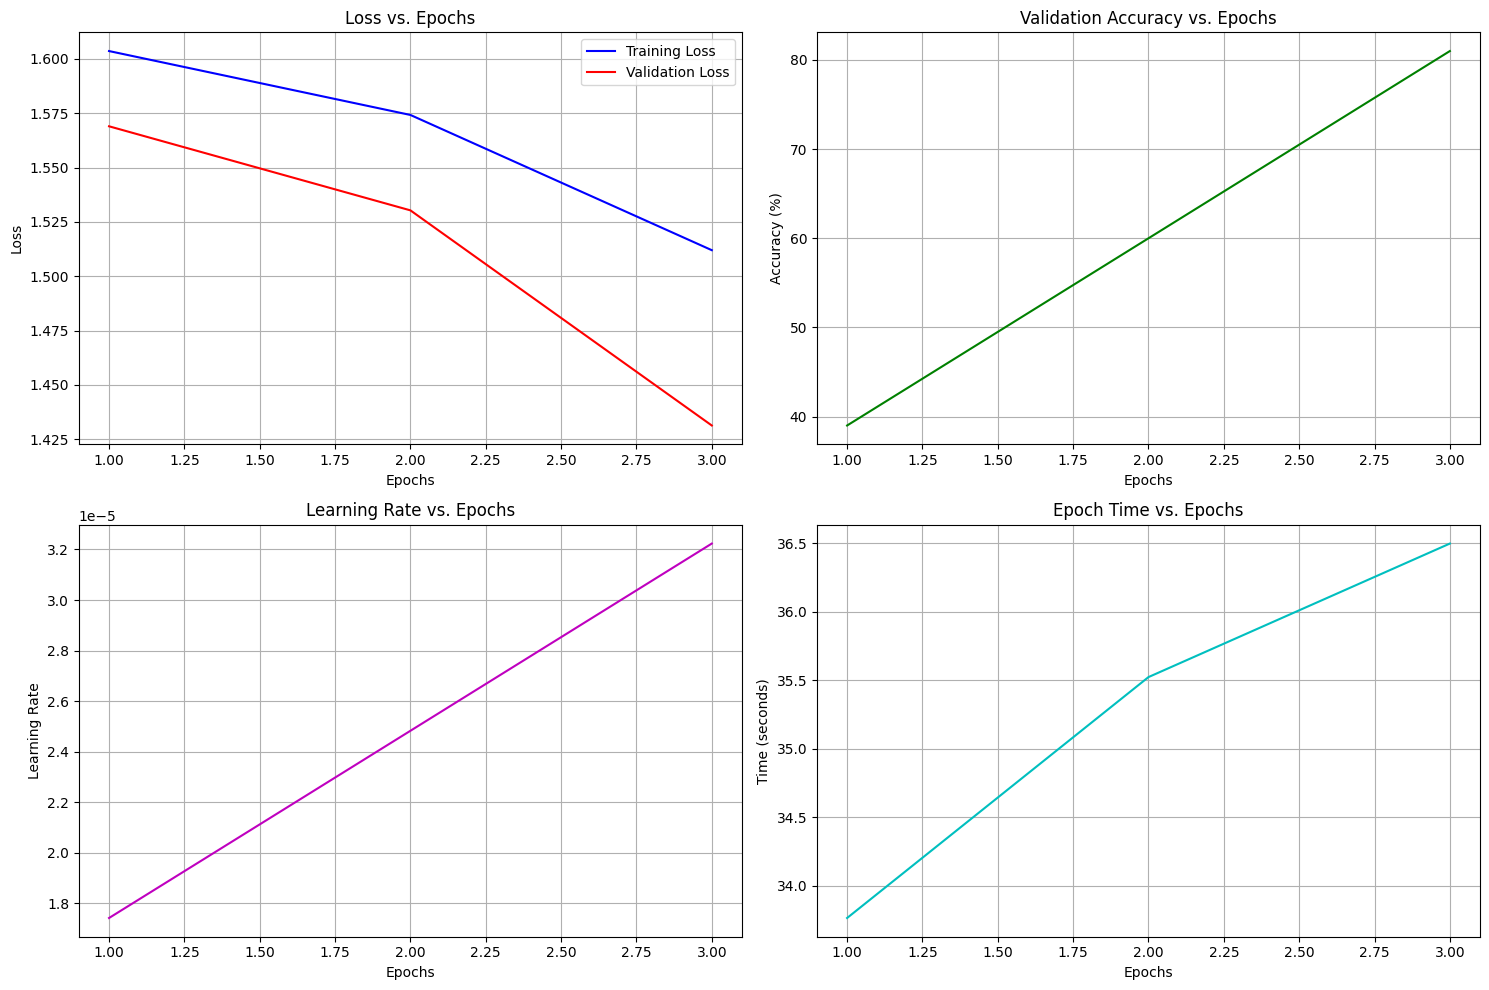

📊 TRAINING SUMMARY (Run ID: 1743241618)
Total training time: 1.89 minutes
Total epochs: 3
Average epoch time: 35.26 seconds
Best validation accuracy: 81.00%
Final validation accuracy: 81.00%
Final training loss: 1.5120
Final validation loss: 1.4314
Available config attributes: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adjust_for_device', 'backbone', 'base_path', 'batch_size', 'checkpoint_dir', 'cyclic_base_lr', 'cyclic_max_lr', 'cyclic_step_size', 'dataset_path', 'device', 'dropout_rate', 'experiment_csv', 'experiment_name', 'experiments_dir', 'fixed_lr', 'freeze_backbone', 'image_size', 'in_colab', 'load', 'log_dir', 'lr_strategy', 'num_epochs', 'save', 'seed', 'set_defaults', 'use_aug

In [150]:
logger.plot_metrics()

# Print training summary
logger.summary()

print("Available config attributes:", dir(config))
print("experiment_csv attribute:", hasattr(config, "experiment_csv"))
if hasattr(config, "experiment_csv"):
    print("Value:", config.experiment_csv)
    
# Log the experiment to CSV
log_run_to_csv(config, model, best_accuracy, total_training_time, logger)

## 📈 Model Evaluation

Now we'll evaluate the model on the test dataset.

Getting predictions:   0%|          | 0/13 [00:00<?, ?it/s]

Model accuracy on test set: 81.00%


,precision,recall,f1-score,support
Chihuahua,0.851852,0.884615,0.867925,52.0
weighted avg,0.897017,0.810000,0.846615,100.0
Japanese_spaniel,0.945946,0.729167,0.823529,48.0
macro avg,0.449449,0.403446,0.422863,100.0
Shih,0.000000,0.000000,0.000000,0.0
Pekinese,0.000000,0.000000,0.000000,0.0


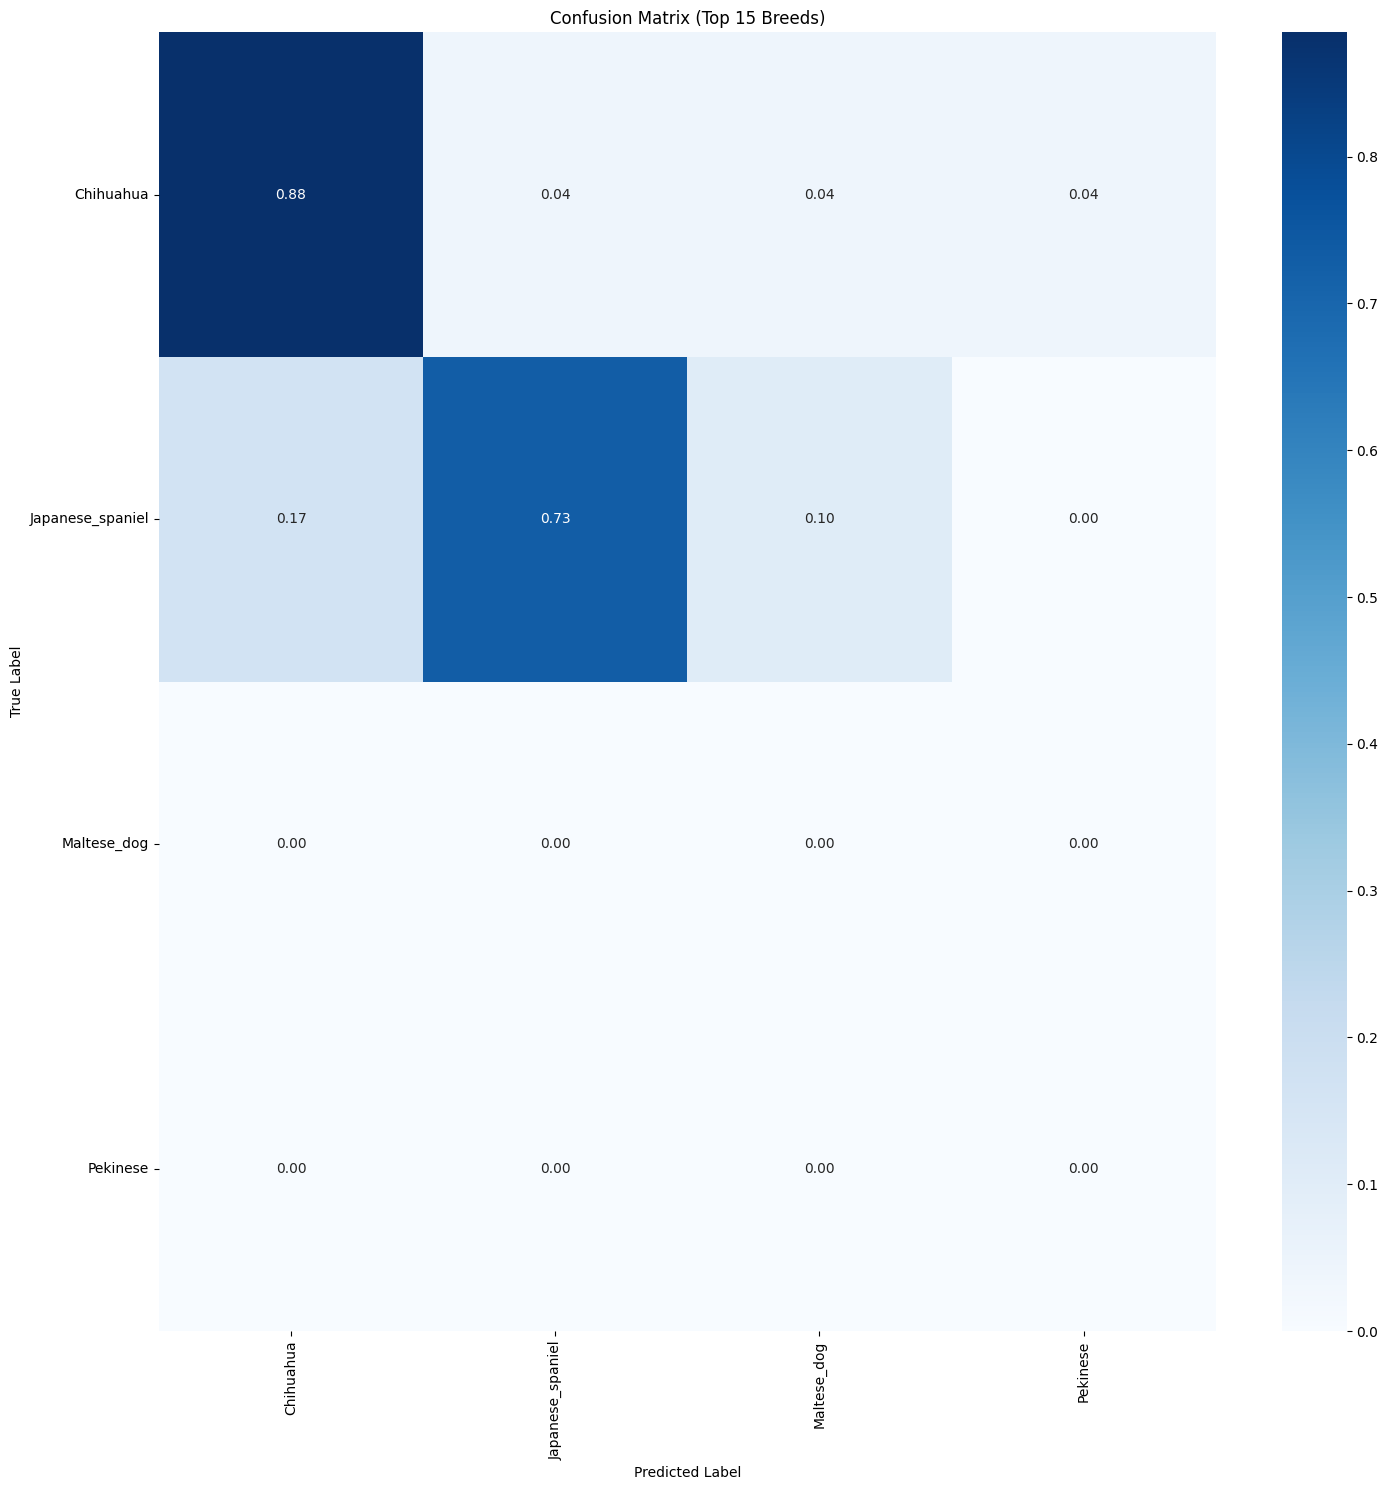

In [151]:
# Model Evaluation

def get_predictions(model, data_loader, device):
    """
    Get model predictions for all images in a data loader
    
    Args:
        model: PyTorch model
        data_loader: DataLoader to iterate through
        device: Device to run on
        
    Returns:
        tuple: (true_labels, predictions, probabilities)
    """
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Getting predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)
            
            # Store results
            all_probs.append(probabilities.cpu())
            all_preds.append(predictions.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate batch results
    all_probs = torch.cat(all_probs, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_labels.numpy(), all_preds.numpy(), all_probs.numpy()

def generate_classification_report(true_labels, predictions, breed_labels):
    """
    Generate a detailed classification report
    
    Args:
        true_labels: Ground truth labels
        predictions: Model predictions
        breed_labels: List of breed class names
        
    Returns:
        DataFrame: Classification metrics by breed
    """
    # Find unique classes in the data
    unique_classes = np.unique(np.concatenate((true_labels, predictions)))
    
    # Create formatted class names only for classes that appear in the data
    labels = unique_classes
    formatted_breeds = [breed_labels[label].split('-')[1] if '-' in breed_labels[label] else breed_labels[label] 
                       for label in labels]
    
    # Get classification report as dictionary
    report = classification_report(true_labels, predictions, 
                                  labels=labels,  # Explicitly specify the labels
                                  target_names=formatted_breeds, 
                                  output_dict=True,
                                  zero_division=0)
    
    # Convert to DataFrame
    df = pd.DataFrame(report).transpose()
    
    # Drop the unnecessary columns
    if 'accuracy' in df.index:
        df = df.drop('accuracy')
    
    # Sort by F1-score
    df = df.sort_values('f1-score', ascending=False)
    
    return df

def visualize_confusion_matrix(true_labels, predictions, breed_labels, top_n=20, figsize=(15, 15)):
    """
    Visualize the confusion matrix for top N breeds
    
    Args:
        true_labels: Ground truth labels
        predictions: Model predictions
        breed_labels: List of breed class names
        top_n: Number of top breeds to include
        figsize: Figure size
    """
    # Get formatted breed names
    formatted_breeds = [breed.split('-')[1] if '-' in breed else breed for breed in breed_labels]
    
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Find the top N breeds with most samples
    breed_counts = np.sum(cm, axis=1)
    top_indices = np.argsort(-breed_counts)[:top_n]
    

    # Extract submatrix for top breeds
    cm_subset = cm[top_indices, :][:, top_indices]
    breed_subset = [formatted_breeds[i] for i in top_indices]

    # Normalize safely to avoid division by zero
    row_sums = cm_subset.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent divide-by-zero
    cm_norm = cm_subset.astype('float') / row_sums

    
    
    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
              xticklabels=breed_subset, yticklabels=breed_subset)
    plt.title(f'Confusion Matrix (Top {top_n} Breeds)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Get predictions
true_labels, predictions, probabilities = get_predictions(model, test_loader, config.device)

# Calculate accuracy
accuracy = np.mean(true_labels == predictions) * 100
print(f"Model accuracy on test set: {accuracy:.2f}%")

# Generate classification report
report_df = generate_classification_report(true_labels, predictions, breed_labels)
display(report_df.head(10))  # Show top 10 breeds

# Visualize confusion matrix
visualize_confusion_matrix(true_labels, predictions, breed_labels, top_n=15)

## 🔍 Inference Examples

Let's test our model on a few sample images to see how it performs.

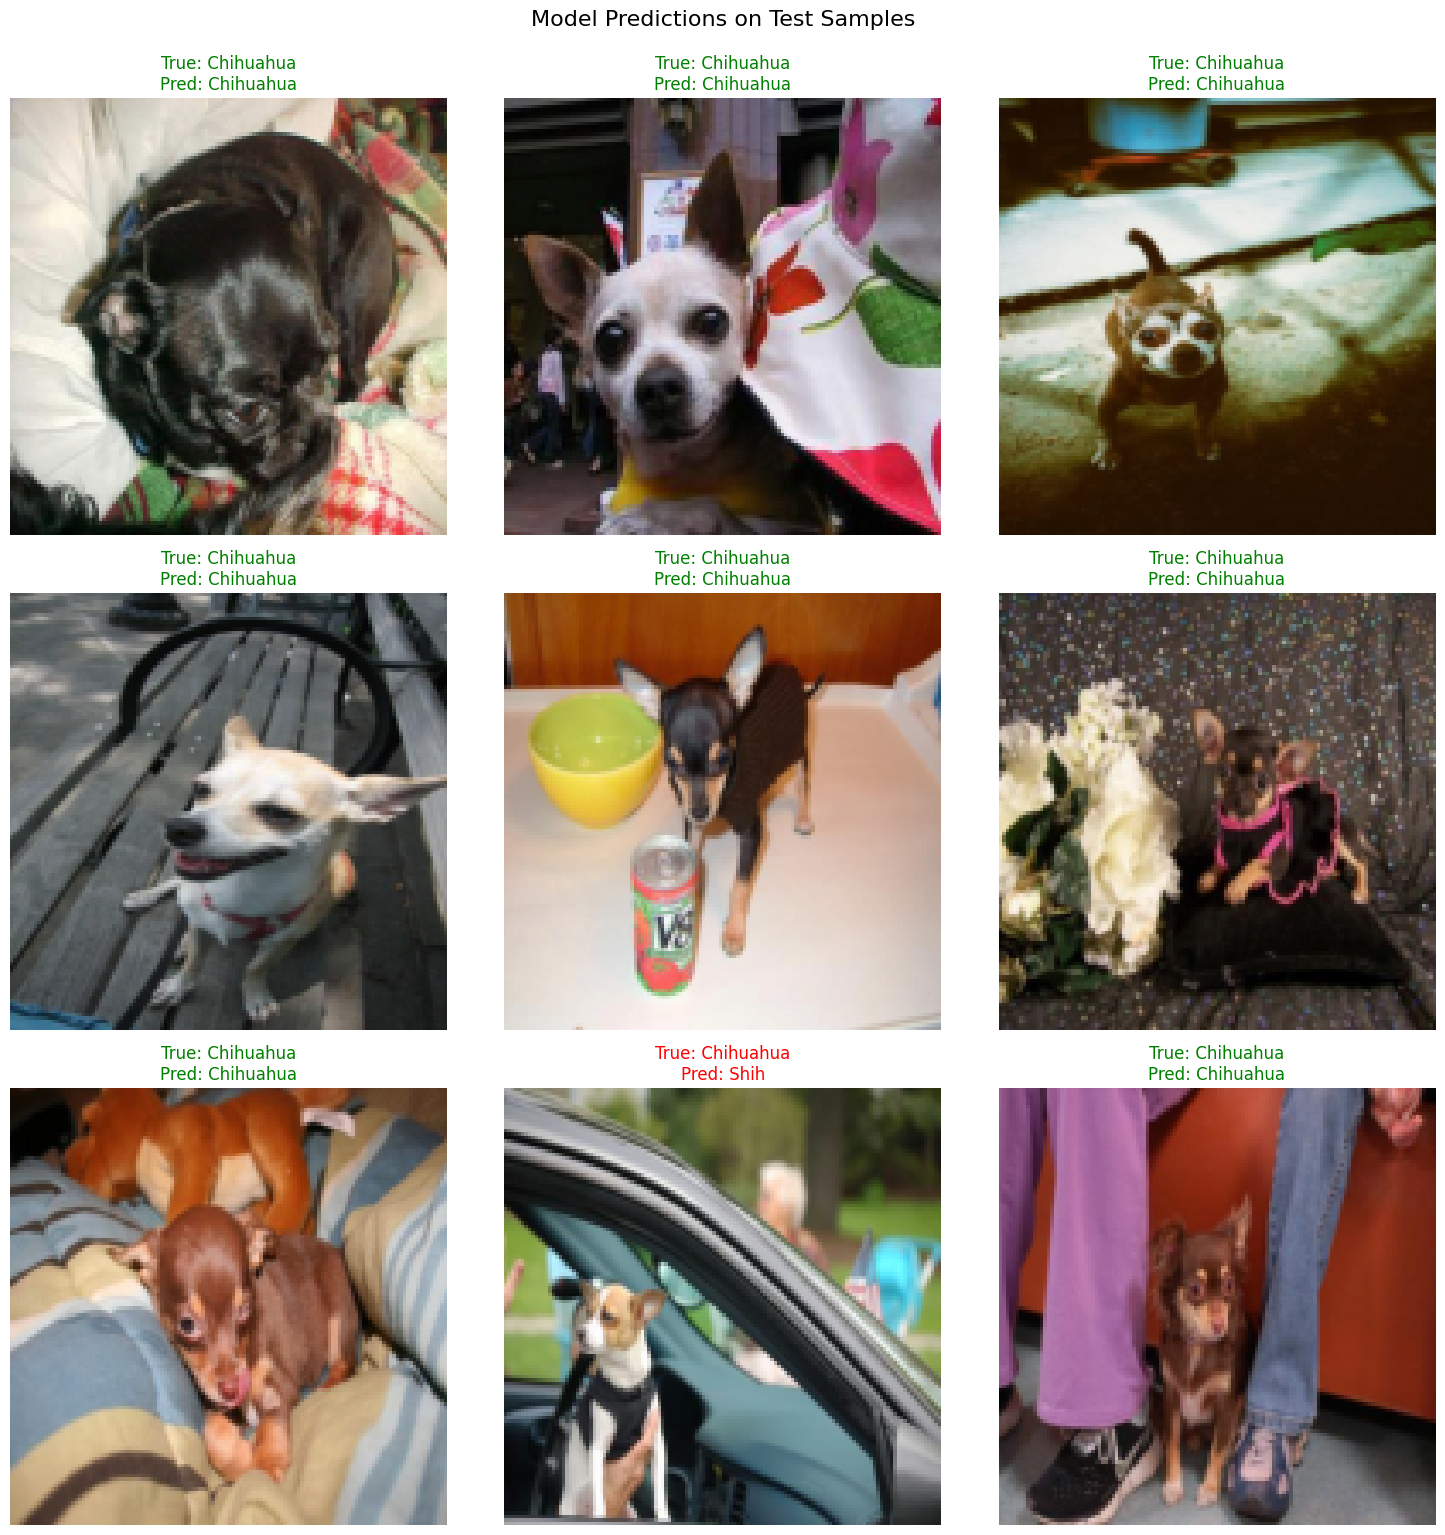

Sample Accuracy: 88.89%


In [152]:
# Inference on Sample Images

def create_breed_prediction_grid(model, test_loader, breed_labels, device, num_samples=9, figsize=(15, 15)):
    """
    Create a grid visualization of model predictions on test data
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test dataset
        breed_labels: List of breed labels
        device: Device to run inference on
        num_samples: Number of samples to visualize in grid
        figsize: Figure size
    """
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []
    
    # Get samples from test loader
    with torch.no_grad():
        for images, labels in test_loader:
            batch_size = images.size(0)
            all_images.append(images)
            all_labels.append(labels)
            
            # Get predictions
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            
            if len(all_images) * batch_size >= num_samples:
                break
    
    # Concatenate all batches
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    
    # Select random indices
    indices = torch.randperm(len(all_images))[:num_samples]
    images = all_images[indices]
    labels = all_labels[indices]
    preds = all_preds[indices]
    
    # Create a grid of images
    rows = int(np.sqrt(num_samples))
    cols = int(np.ceil(num_samples / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, (img, label, pred) in enumerate(zip(images, labels, preds)):
        if i >= num_samples:
            break
            
        # Denormalize the image
        img = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Get breed names
        true_breed = breed_labels[label].split('-')[1] if '-' in breed_labels[label] else breed_labels[label]
        pred_breed = breed_labels[pred].split('-')[1] if '-' in breed_labels[pred] else breed_labels[pred]
        
        # Display the image
        axes[i].imshow(img)
        
        # Add colored title based on prediction correctness
        color = 'green' if label == pred else 'red'
        axes[i].set_title(f"True: {true_breed}\nPred: {pred_breed}", color=color)
        axes[i].axis('off')
    
    # Turn off any unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Model Predictions on Test Samples", fontsize=16, y=1.02)
    plt.show()
    
    # Print accuracy on these samples
    accuracy = (labels == preds).sum().item() / len(labels) * 100
    print(f"Sample Accuracy: {accuracy:.2f}%")

# Create prediction grid
create_breed_prediction_grid(model, test_loader, breed_labels, config.device, num_samples=9)

## ⚙️ Performance Metrics

Let's measure the inference speed and other performance metrics of our model.

In [153]:
# Performance Metrics

def measure_inference_time(model, input_size=(3, 224, 224), device="cpu", num_warmup=10, num_runs=100):
    """
    Measure inference time of the model
    
    Args:
        model: PyTorch model
        input_size: Input tensor size (channels, height, width)
        device: Device to run inference on
        num_warmup: Number of warmup runs
        num_runs: Number of timed runs
        
    Returns:
        dict: Dictionary with inference metrics
    """
    model.eval()
    model = model.to(device)
    
    # Create dummy input
    dummy_input = torch.randn(1, *input_size, device=device)
    
    # Warmup runs
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(dummy_input)
    
    # Timed runs
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)
    end_time = time.time()
    
    # Calculate metrics
    total_time = end_time - start_time
    avg_time = total_time / num_runs
    fps = 1.0 / avg_time
    
    return {
        "avg_inference_time_ms": avg_time * 1000,
        "fps": fps,
        "total_time_s": total_time,
        "runs": num_runs
    }

# Measure inference time
performance = measure_inference_time(model, input_size=(3, *config.image_size), device=config.device)

print("\n📊 Performance Metrics:")
print(f"📏 Model Size: {model.get_model_size():.2f} MB")
print(f"🔢 Total Parameters: {model.get_parameter_count():,}")
print(f"⚡ Avg. Inference Time: {performance['avg_inference_time_ms']:.2f} ms")
print(f"🚀 Frames Per Second: {performance['fps']:.2f}")


📊 Performance Metrics:
📏 Model Size: 17.96 MB
🔢 Total Parameters: 4,665,985
⚡ Avg. Inference Time: 43.56 ms
🚀 Frames Per Second: 22.96



📊 COMPARISON OF TRAINING RUNS


,run_id,backbone,final_accuracy,model_size_mb,total_train_time_min,augmentation,lr_strategy,device,epochs
20,1743240870,efficientnet,81.00,17.96,1.900000,Yes,cyclic,cpu,3
21,1743241618,efficientnet,81.00,17.96,1.860000,Yes,cyclic,cpu,3
15,1742998539,resnet50,80.65,NaN,41.891167,Yes,cyclic,cuda,20
14,1742994361,resnet50,80.61,NaN,33.166667,Yes,cyclic,cuda,20
19,1743092734,efficientnet,80.08,16.16,67.117167,Yes,cyclic,cuda,35
16,1743001513,resnet50,79.62,NaN,42.087833,Yes,cyclic,cuda,25
18,1743086136,efficientnet,79.18,16.16,54.865000,Yes,cyclic,cuda,30
17,1743081817,efficientnet,77.75,16.16,45.336500,Yes,cyclic,cuda,25
10,1742592459,mobilenet,74.39,NaN,18.766000,Yes,fixed,cuda,10
9,1742590639,mobilenet,74.38,NaN,15.782000,Yes,fixed,cuda,10


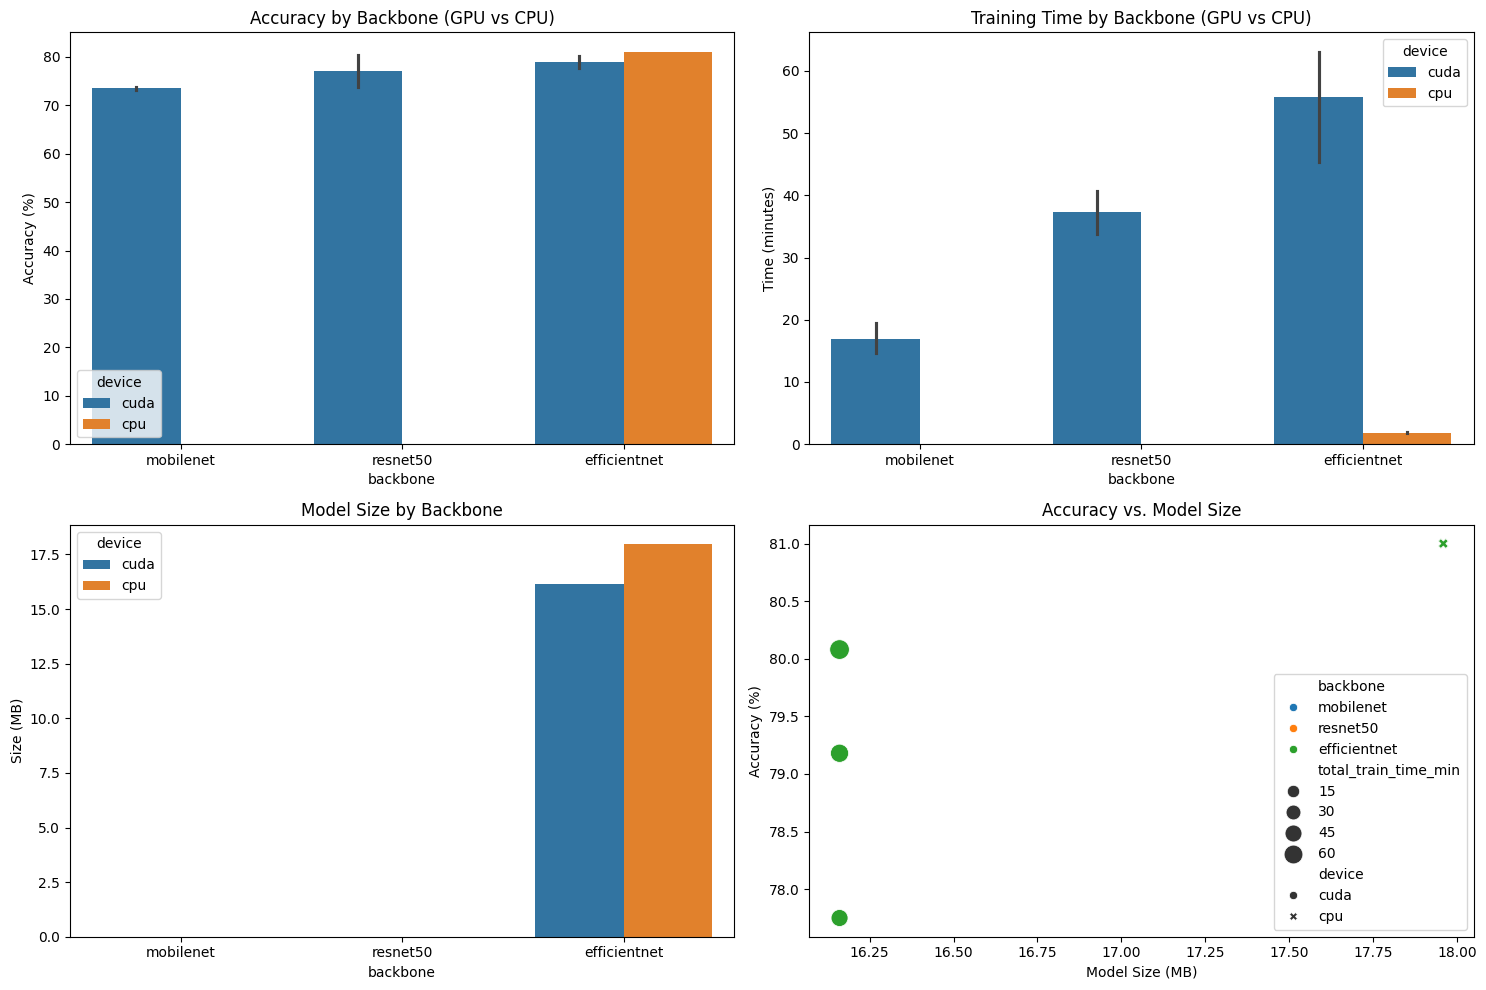

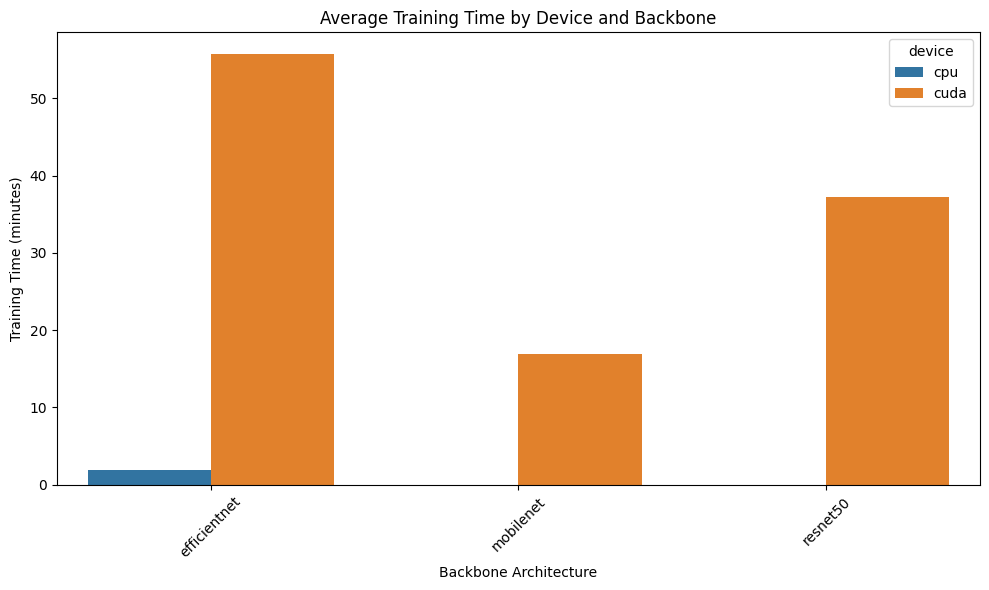

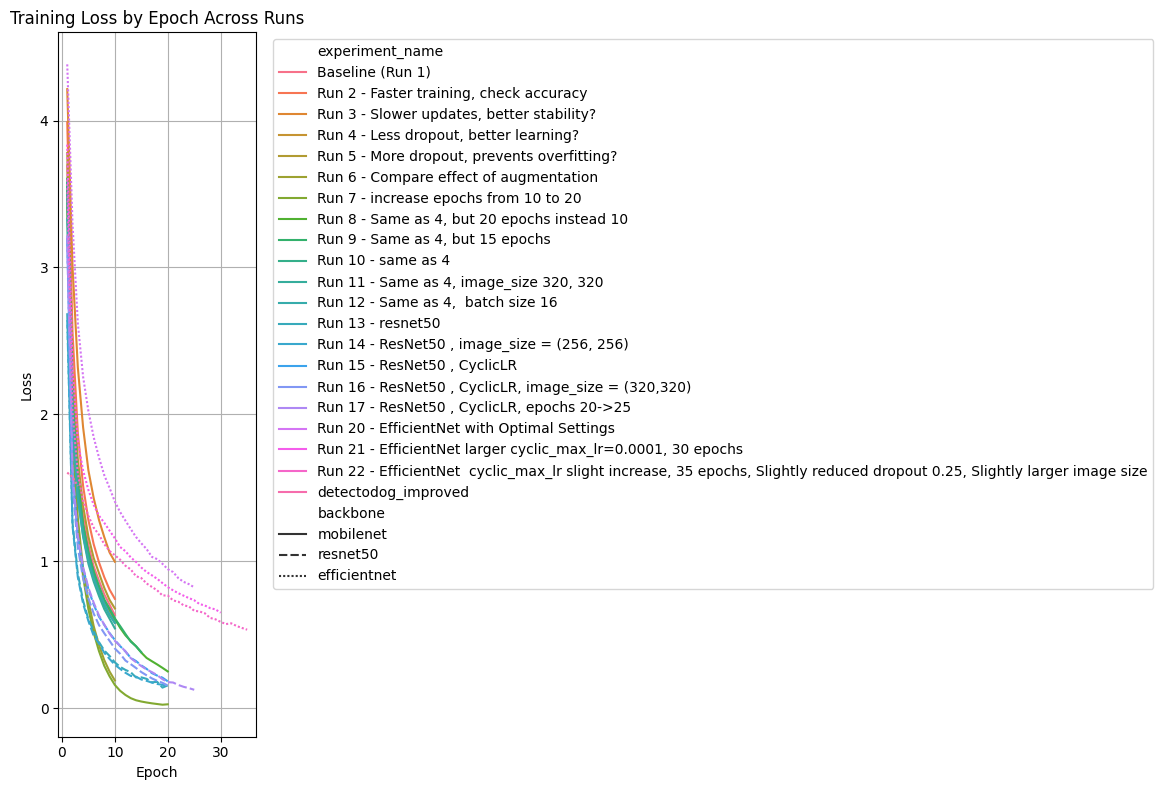

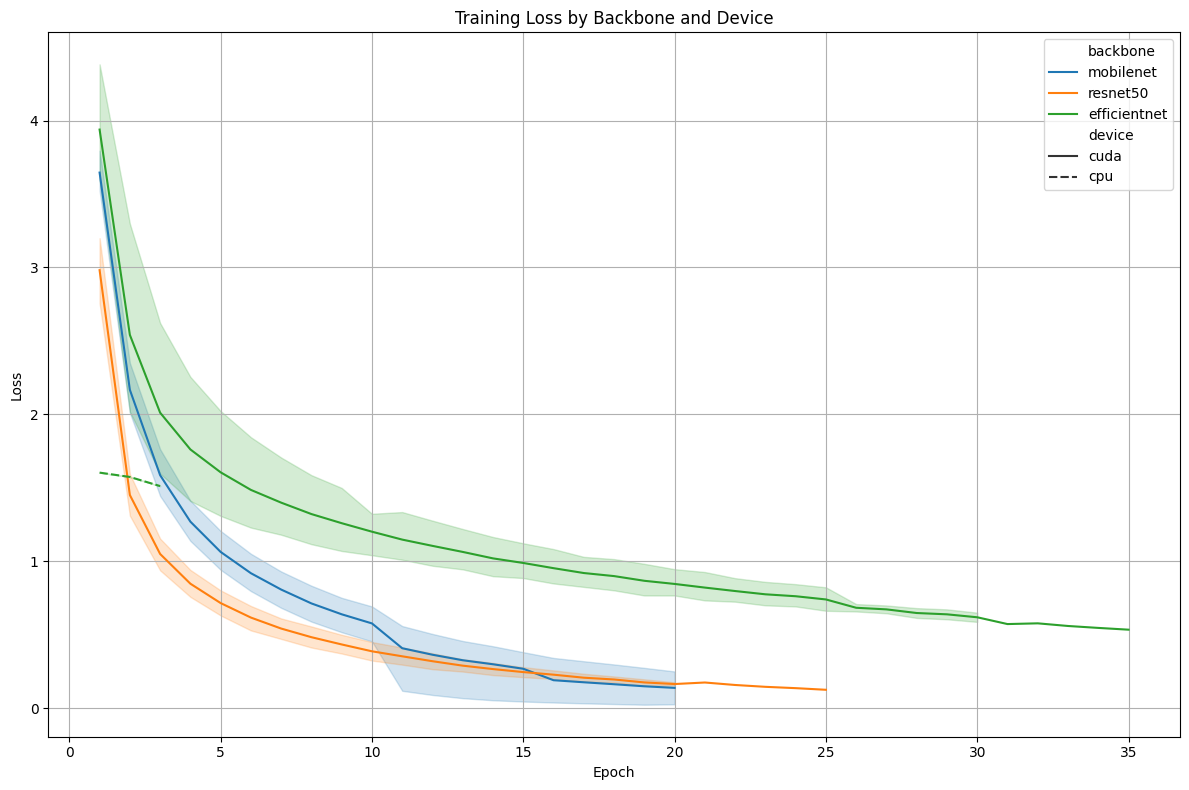


📊 Final Epoch Loss by Run:


/tmp/ipykernel_1284934/3163787282.py:566: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_epochs = merged_df.groupby('run_id').apply(lambda x: x.nlargest(1, 'epoch')).reset_index(drop=True)


,run_id,experiment_name,backbone,epoch,loss
6,1742583814,Run 7 - increase epochs from 10 to 20,mobilenet,20,0.026481
16,1743001513,"Run 17 - ResNet50 , CyclicLR, epochs 20->25",resnet50,25,0.125280
13,1742640774,"Run 14 - ResNet50 , image_size = (256, 256)",resnet50,20,0.152533
15,1742998539,"Run 16 - ResNet50 , CyclicLR, image_size = (32...",resnet50,20,0.154373
12,1742637985,Run 13 - resnet50,resnet50,20,0.155284
14,1742994361,"Run 15 - ResNet50 , CyclicLR",resnet50,20,0.182727
5,1742581415,Run 6 - Compare effect of augmentation,mobilenet,10,0.188699
7,1742586022,"Run 8 - Same as 4, but 20 epochs instead 10",mobilenet,20,0.250145
8,1742588050,"Run 9 - Same as 4, but 15 epochs",mobilenet,15,0.381249
19,1743092734,Run 22 - EfficientNet cyclic_max_lr slight in...,efficientnet,35,0.534444


In [154]:
# Load and compare previous runs if available
try:
    experiments_dir = "experiments"
    compare_runs(os.path.join(experiments_dir, "training_runs_v4.csv"))
    visualize_epoch_loss_history(
        os.path.join(experiments_dir, "epoch_loss.csv"),
        os.path.join(experiments_dir, "training_runs_v4.csv")
    )
except Exception as e:
    print(f"Could not compare runs: {e}")
    print("This is probably your first run or the experiment CSV file doesn't exist yet.")

## 💾 Save Final Model

Finally, let's save our trained model for future use.

In [155]:
# Save the model
final_model_path = os.path.join(config.log_dir, f"{config.experiment_name}_final.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': {
        'backbone': config.backbone,
        'num_classes': len(breed_labels),
        'dropout_rate': config.dropout_rate
    },
    'accuracy': accuracy,
    'breed_labels': breed_labels
}, final_model_path)

print(f"✅ Model saved to: {final_model_path}")

✅ Model saved to: logs/detectodog_improved_final.pth


## 🏁 Conclusion

In this notebook, we've built and trained a dog breed classifier using transfer learning. Our model can identify dog breeds with high accuracy.

### Key Accomplishments
- Explored and processed the Stanford Dogs Dataset
- Implemented data augmentation for better generalization
- Created a flexible model architecture with multiple backbone options
- Trained the model with optimal hyperparameters
- Evaluated performance with detailed metrics
- Created a system for inference on new images

### Next Steps
- Try ensemble methods for better accuracy
- Implement model quantization for faster inference
- Create a web interface for user uploads
- Expand to more breeds or related tasks

In [156]:
print(f"📊 TRAINING SUMMARY (Run ID: {logger.run_id})")
print("=" * 50)
print(f"Total training time: {total_training_time/60:.2f} minutes")
print(f"Total epochs: {config.num_epochs}")
print(f"Average epoch time: {sum(logger.epoch_times)/len(logger.epoch_times):.2f} seconds")
print(f"Best validation accuracy: {max(logger.val_accuracies):.2f}%")
print(f"Final validation accuracy: {logger.val_accuracies[-1]:.2f}%")
print(f"Final training loss: {logger.train_losses[-1]:.4f}")
print(f"Final validation loss: {logger.val_losses[-1]:.4f}")
print("=" * 50)

📊 TRAINING SUMMARY (Run ID: 1743241618)
Total training time: 1.86 minutes
Total epochs: 3
Average epoch time: 35.26 seconds
Best validation accuracy: 81.00%
Final validation accuracy: 81.00%
Final training loss: 1.5120
Final validation loss: 1.4314
